In [3]:
%load_ext autoreload
%autoreload 2

import os
import torch
import matplotlib.pyplot as plt
from math import log2
import numpy as np
import math
from tqdm import tqdm
import gc
from copy import deepcopy

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

from mpl_toolkits.mplot3d import Axes3D
from typing import Union, List
from IPython.display import HTML

from transformers import Qwen2ForCausalLM, Qwen2Tokenizer, Qwen2Config
from model.int_qwen import replace_decoders, replace_norm, replace_lm_head
from datasets import load_dataset, DownloadMode

from utils.ppl_eval import *
from model.int_qwen import a_quantizer, w_quantizer, r_quantizer, shift_matmul, shift_qk_matmul, shift_rv_matmul, A_QUANT_PARAMS, W_QUANT_PARAMS, R_QUANT_PARAMS

# disable any assertion

device      = "cuda:4"
ref_device  = "cuda:5"

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.dpi"] = 400
plt.rcParams["font.size"] = 6

GQY_MODELS      = os.environ["GQY_MODELS"]
QWEN_PATH       = os.path.join(GQY_MODELS, "Qwen2.5-0.5B-Instruct")
WIKITEXT_PATH   = os.path.join(GQY_MODELS, "wikitext/")

print(f"QWEN_PATH: {QWEN_PATH}")
print(f"WIKITEXT_PATH: {WIKITEXT_PATH}")

# export environment variables
os.environ["CUDA_LAUNCH_BLOCKING"]         = "1"
os.environ["TORCHINDUCTOR_FX_GRAPH_CACHE"] = "1"

# set huggingface mirror
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
QWEN_PATH: /home/gqy/models/Qwen2.5-0.5B-Instruct
WIKITEXT_PATH: /home/gqy/models/wikitext/


In [4]:
if "ref_model" not in globals():
    tokenizer       = Qwen2Tokenizer.from_pretrained(QWEN_PATH)
    print("Loaded tokenizer")
    dataset         = load_dataset(WIKITEXT_PATH, "default", split="test", download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS)
    print("Loaded dataset")
    ref_model_cpu   = Qwen2ForCausalLM.from_pretrained(QWEN_PATH, torch_dtype=torch.float32)
    ref_model       = deepcopy(ref_model_cpu).to(ref_device)
    print("Loaded reference model")
    evaluator = Evaluator(dataset, tokenizer, n_samples=50)
    print("Loaded evaluator")

Loaded tokenizer
Loaded dataset
Loaded reference model


Token indices sequence length is longer than the specified maximum sequence length for this model (2392094 > 131072). Running this sequence through the model will result in indexing errors


Loaded evaluator


In [5]:
# apply pot scale
for m in ["model"]:
    try:
        print(f"Removing {m}")
        # recursively delete all tensors
        m = globals().pop(m)
        m = m.to("cpu")
        del m
    except KeyError:
        pass

# load pretrained
model = deepcopy(ref_model_cpu).to(device)

# quantize and compile
torch.set_float32_matmul_precision('high')
replace_decoders    (model, device)
replace_norm        (model, device)
replace_lm_head     (model, device)
# model = torch.compile(model, fullgraph=True)
# evaluate perplexity
def evaluate_ppl(_model, _device):
    with torch.no_grad():
        with torch.cuda.device(_device):
            ppl = evaluator.evaluate(_model, _device)

    print(f"Perplexity: {ppl:.4f}")

# evaluate_ppl(model, device)
# evaluate_ppl(ref_model, ref_device)

# float                                     13.9447
# replaced head only                        14.6468
# increased O_w of head                     14.5253
# increased O_res to 12, doesnt work        14.5254
# increased A bits to 8                     14.4439
# replaced norm                             43.7045
# 1<<9 ~ 1<<21, why?                        14.445
# 1<<32,                                    14.4481
# 1<<24,                                    14.4481
# 1<<22,                                    14.4492
# 1<<21                                     36.17
# -3 ~ 22                                   14.4481
# int version silu:                         14.4360
# replace wu and wg                         14.9439
# 4bit weight, -0 scale2, MLP 11 O_w        15.7506 *
# 4bit weight, -1 scale2                    16.0234
# 5bit weight, -1 scale2                    14.6544 *
# 5bit weight, -0 scale2, MLP 13 O_w        15.0147
# 5bit weight, -0 scale2, MLP 12 O_w        14.5445
# 5bit weight, -0 scale2, MLP 11 O_w        14.5573
# 5bit weight, -0 scale2, MLP 10 O_w        14.5592
# 4bit weight, -0 scale2, MLP 11 O_w, A6    15.9191 *
# 4bit, replaced MHA components             15.9350
# 4bit, quantized QKV                       16.8564
# 4bit, integer bias                        16.8609
# replaced rope, 12 iteration               16.8353
# reduce theta bits back to 24 bits         16.8568
# replaced attention, softmax, and o        19.3349
# increased O_w of attention                17.7694
# increased a to 8 bit                      16.4536
# with truncated bias                       16.4532
# use separate trunc for qk and v           16.4482
# 5bit w, 8bit a                            14,9434
# freeze                                    14.9423
# golden                                    14.9219 64.

Removing model


24it [00:00, 62.82it/s]


In [6]:
def test_prefill(_model, _file):
    # input ids
    input_text = open("/usr/include/stdio.h").read()
    input_ids = tokenizer.encode(input_text, add_special_tokens=True, return_tensors="pt").to(_model.device)
    input_ids = input_ids[:, :128]
    # warm up
    _model(input_ids)
    # profile
    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
        record_shapes=True, 
        profile_memory=True, 
        with_stack=True,
        with_modules=True
    ) as prof:
        with record_function("model_inference"):
            outputs = _model(input_ids)
    # export to chrome trace
    prof.export_chrome_trace(f"{_file}.json")
    # decode output
    logits = outputs.logits
    output_ids = logits[0].argmax(dim=-1)
    # tokens = tokenizer.convert_ids_to_tokens(output_ids.squeeze().tolist())
    tokens = tokenizer.decode(output_ids.squeeze().tolist())
    print("".join(tokens))
    
# test_prefill(model,     "trace_quant")
print("*"*80)
# test_prefill(ref_model, "trace_ref")
    

********************************************************************************


In [7]:
def test_generate(_model):
    input_text = "In the beginning God created the heavens and the earth. Now the earth was formless and empty, darkness was over the surface of the deep, and the Spirit of God was hovering over the waters. And God said,"
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
    T = 32
    S = input_ids.size(1)
    print("*" * 80)
    input_ids = input_ids.to(_model.device)
    output_ids = _model.generate(input_ids[..., :S], max_length=(S+T), do_sample=True, temperature=0.8)
    output_text = tokenizer.decode(output_ids.squeeze().tolist())
    print(output_text)
    print("*" * 80)

# test_generate(ref_model)
# test_generate(model)


In [8]:
tensor_values = capture_dut(model, tokenizer, device)

cls_decoder_id: 24


In [9]:
plot_tensor = plot_tensor_cls()
plot_tensor.status = False

def plot_decoder_tensors(decoder_id):
    global tensor_values
    
    decoder = model.model.layers[decoder_id]
    MHA     = decoder.MHA
    MLP     = decoder.MLP
    # some hyper-parameters
    C       = MHA.C
    GA      = MHA.GA
    GW      = MHA.GW
    GR      = MHA.GR
    H       = MHA.H
    KVH     = MHA.KVH
    HC      = MHA.HC
    CM      = MLP.CM

    # get input
    x, position_embedding, mask, pos_ids, kv_cache, cache_pos = tensor_values[decoder_id]["MHA"]["args"] 
    B, T, _ = x.shape

    # simulate MHA
    residual            = x
    x                   = x                                                                         ; plot_tensor(x.view(-1, C),                decoder_id,  "MHA_x_outlier",               mode="outlier")
    xln                 = MHA.rmsnorm(x)                                                            ; plot_tensor(xln,                          decoder_id,  "MHA_x_ln");   
    xln                 = xln                                                                       ; plot_tensor(xln.view(-1, C),              decoder_id,  "MHA_x_ln_outlier",            mode="outlier")
    xlnq, xlns          = a_quantizer(xln, fused=False)                                             ; plot_tensor([xlnq, xlns],                 decoder_id,  ["MHA_x_q", "MHA_x_s"],        mode="multi")
    q_trunc             = shift_matmul(xlnq, xlns, MHA.wq_q, MHA.wq_s1, MHA.wq_s2, C,   H*HC, GA, GW) >> MHA.Trunc_qk
    k_trunc             = shift_matmul(xlnq, xlns, MHA.wk_q, MHA.wk_s1, MHA.wk_s2, C, KVH*HC, GA, GW) >> MHA.Trunc_qk
    v_trunc             = shift_matmul(xlnq, xlns, MHA.wv_q, MHA.wv_s1, MHA.wv_s2, C, KVH*HC, GA, GW) >> MHA.Trunc_v    
    # add bias
    q_trunc             = q_trunc + MHA.bq
    k_trunc             = k_trunc + MHA.bk
    v_trunc             = v_trunc + MHA.bv                                                          ; plot_tensor([q_trunc, k_trunc, v_trunc],  decoder_id,  ["MHA_q", "MHA_k", "MHA_v"],   mode="stacked")
    # reshape head
    q_trunc             = q_trunc.view(B, T, H,   HC).transpose(1, 2).contiguous() 
    k_trunc             = k_trunc.view(B, T, KVH, HC).transpose(1, 2).contiguous() 
    v_trunc             = v_trunc.view(B, T, KVH, HC).transpose(1, 2).contiguous() 
    # rope
    cos_val, sin_val    = position_embedding                                                        ; plot_tensor([cos_val, sin_val],           decoder_id,  ["MHA_cos", "MHA_sin"],        mode="stacked")
    cos_val             = torch.repeat_interleave(cos_val, 2, dim=-1)
    sin_val             = torch.repeat_interleave(sin_val, 2, dim=-1)
    qrot                = (q_trunc * cos_val + MHA.rotate(q_trunc) * sin_val) >> MHA.Trunc_rot                       
    krot                = (k_trunc * cos_val + MHA.rotate(k_trunc) * sin_val) >> MHA.Trunc_rot      ; plot_tensor([qrot, krot],                 decoder_id,  ["MHA_qrot", "MHA_krot"],      mode="stacked")
    v_trunc             = (v_trunc                                          )                       ; plot_tensor(v_trunc,                      decoder_id,  "MHA_v_trunc")
    # plot qkv outlier
    qrot                = qrot                                                                      ; plot_tensor(qrot      .view(-1, HC*H  ),  decoder_id,  "MHA_qrot_outlier",            mode="outlier")
    krot                = krot                                                                      ; plot_tensor(krot      .view(-1, HC*KVH),  decoder_id,  "MHA_krot_outlier",            mode="outlier")
    v_trunc             = v_trunc                                                                   ; plot_tensor(v_trunc   .view(-1, HC*KVH),  decoder_id,  "MHA_v_outlier",               mode="outlier")
    # update kv cache
    S = T
    # get mask
    assert mask is None
    mask                = torch.triu(torch.ones(T, T), diagonal=1).to(x.device)
    mask                = mask.masked_fill(mask == 1, -1e9).int()
    mask                = mask[None, None, :, :] 
    # pad v, to next multiple of GA
    if S % GR != 0:
        pad_length = GR - (S % GR)
        print(f"Padding, original S: {S}, pad_length: {pad_length}")
        S = S + pad_length
        krot    = torch.nn.functional.pad(krot,     (0, 0, 0, pad_length), value=0)
        v_trunc = torch.nn.functional.pad(v_trunc,  (0, 0, 0, pad_length), value=0)
        mask    = torch.nn.functional.pad(mask,     (0,       pad_length), value=-1e9)
    # repeat kv
    if H != KVH:
        krot            = MHA.repeat_kv(krot,    H // KVH)
        v_trunc         = MHA.repeat_kv(v_trunc, H // KVH)
    # quantize q, k, v
    q_q, q_s            = a_quantizer(qrot, fused=False)                                                        ; plot_tensor([q_q, q_s],           decoder_id,  ["MHA_q_q", "MHA_q_s"],        mode="multi")
    k_q, k_s            = a_quantizer(krot, fused=False)                                                        ; plot_tensor([k_q, k_s],           decoder_id,  ["MHA_k_q", "MHA_k_s"],        mode="multi")
    # calculate attention
    r                   = shift_qk_matmul(q_q, q_s,  k_q,  k_s, B, H, T, S, HC, GA) >> MHA.Trunc_r              ; plot_tensor(r,                    decoder_id,  "MHA_r")
    r_softmax           = MHA.softmax(r, mask)                                                                  ; plot_tensor(r_softmax,            decoder_id,  "MHA_r_softmax")
    # plot r_softmax outlier
    r_softmax           = r_softmax                                                                             ; plot_tensor(r_softmax.view(-1, T),decoder_id,  "MHA_r_softmax_outlier",       mode="outlier");   
    # quantize r and v
    r_q, r_s            = r_quantizer(r_softmax, fused=False)                                                   ; plot_tensor([r_q, r_s],           decoder_id,  ["MHA_r_q", "MHA_r_s"],        mode="multi")
    vt_q, vt_s          = r_quantizer(v_trunc.transpose(-1, -2).contiguous(), fused=False)                      ; plot_tensor([vt_q, vt_s],         decoder_id,  ["MHA_vt_q", "MHA_vt_s"],      mode="multi")
    # calculate rv
    a                   = shift_rv_matmul(r_q, r_s, vt_q, vt_s, B, H, T, S, HC, GR) >> MHA.Trunc_a              ; plot_tensor(a,                    decoder_id,  "MHA_a")
    # plot a outlier
    a                   = a.transpose(1, 2).reshape(B, T, C)                                 
    a_q, a_s            = a_quantizer(a, fused=False)                                                           ; plot_tensor([a_q, a_s],           decoder_id,  ["MHA_a_q", "MHA_a_s"],        mode="multi")
    # plot a outlier
    a                   = a                                                                                     ; plot_tensor(a.view(-1, C).float(),decoder_id,  "MHA_a_outlier",                 mode="outlier")
    # output projection
    o                   = shift_matmul(a_q, a_s, MHA.wo_q, MHA.wo_s1, MHA.wo_s2, C, C, GA, GW) >> MHA.Trunc_o   ; plot_tensor(o,                    decoder_id,  "MHA_o")
    # plot o outlier
    o                   = o                                                                                     ; plot_tensor(o.view(-1, C).float(),decoder_id,  "MHA_o_outlier",                 mode="outlier")
    # residual
    o                   = residual + o
    # get ref
    o_ref               = tensor_values[decoder_id]["MHA"]["output"][0]
    compare_tensor(o, o_ref, f"Decoder {decoder_id} MHA")
    
    # simulate MLP
    x                   = o
    residual            = x
    # plot x outlier
    x                   = x                                                                                     ; plot_tensor(x.view(-1, C).float(),decoder_id,  "MLP_x_outlier",                 mode="outlier")
    # simulate MLP
    xln                 = MLP.rmsnorm(x)                                                                        ; plot_tensor(xln,                 decoder_id,  "MLP_x_ln")
    # plot x_ln outlier
    xln                 = xln                                                                                  ; plot_tensor(xln.view(-1, C).float(),decoder_id,  "MLP_x_ln_outlier",             mode="outlier")
    x_q, x_s            = a_quantizer(xln, fused=False)                                                        ; plot_tensor([x_q, x_s],           decoder_id,  ["MLP_x_q", "MLP_x_s"],          mode="multi")
    xg                  = shift_matmul(x_q, x_s, MLP.wg_q, MLP.wg_s1, MLP.wg_s2, C, CM, GA, GW) >> MLP.Trunc_ug ; plot_tensor(xg,                   decoder_id,  "MLP_xg")
    xu                  = shift_matmul(x_q, x_s, MLP.wu_q, MLP.wu_s1, MLP.wu_s2, C, CM, GA, GW) >> MLP.Trunc_ug ; plot_tensor(xu,                   decoder_id,  "MLP_xu")
    xg                  = MLP.silu(xg)                                                                          ; plot_tensor(xg,                   decoder_id,  "MLP_xg_silu")
    # plot xu and xg outlier
    xu                  = xu                                                                                    ; plot_tensor(xu.view(-1, CM).float(),decoder_id,  "MLP_xu_outlier",                 mode="outlier")
    xg                  = xg                                                                                    ; plot_tensor(xg.view(-1, CM).float(),decoder_id,  "MLP_xg_outlier",                 mode="outlier")
    # element-wise multiplication
    x                   = (xu * xg) >> MLP.Trunc_mul                                                            ; plot_tensor(x,                    decoder_id,  "MLP_x")
    # plot x_mul outlier
    x                   = x                                                                                     ; plot_tensor(x.view(-1, CM).float(),decoder_id,  "MLP_x_mul_outlier",             mode="outlier")
    x_q, x_s            = a_quantizer(x, fused=False)                                                           ; plot_tensor([x_q, x_s],           decoder_id,  ["MLP_x_q", "MLP_x_s"],          mode="multi")
    x                   = shift_matmul(x_q, x_s, MLP.wd_q, MLP.wd_s1, MLP.wd_s2, CM, C, GA, GW) >> MLP.Trunc_d  ; plot_tensor(x,                    decoder_id,  "MLP_x")
    # plot xd outlier
    x                   = x                                                                                     ; plot_tensor(x.view(-1, C).float(),decoder_id,  "MLP_x_outlier",                 mode="outlier")
    # residual
    x                   = residual + x
    # get ref
    x_ref               = tensor_values[decoder_id]["MLP"]["output"][0]
    compare_tensor(x, x_ref, f"Decoder {decoder_id} MLP")
    print("All tensors are checked!")
    
# # plot_decoder_tensors(0)
for l in range(len(model.model.layers)):
    try:
        plot_decoder_tensors(l)
    except KeyboardInterrupt:
        break
    

--------------------------------------compare tensor--------------------------------------
Decoder 0 MHA                  shape: torch.Size([128, 896]), min_x: -3.84000e+02, max_x: 2.29600e+03, elems: ['     -48', '     -40', '      24', '     -55', '      14', '      53', '      13', '      35', '      29', '    -117']
Decoder 0 MHA                  shape: torch.Size([128, 896]), min_y: -3.84000e+02, max_y: 2.29600e+03, elems: ['     -48', '     -40', '      24', '     -55', '      14', '      53', '      13', '      35', '      29', '    -117']
Decoder 0 MHA                       Average diff: 0.0000,           Average x: 47.3463,             Average y:47.3463,            allclose: True
------------------------------------------------------------------------------------------
--------------------------------------compare tensor--------------------------------------
Decoder 0 MLP                  shape: torch.Size([128, 896]), min_x: -1.08040e+04, max_x: 1.43800e+04, elems: ['    2743

In [10]:
# some aux funcs
def save_tensor(t: Union[torch.Tensor, List], decoder_id, dtype, name):
    path = f"binaries/decoder_{decoder_id}"
    if not os.path.exists(path):
        os.makedirs(path)
    if isinstance(t, list):
        t = torch.tensor(t)
    print(f"Saving {name}, shape: {t.shape}, dtype: {t.dtype}")

    # only integer values
    t = t.to(dtype)
    t = t.cpu().detach().numpy().flatten()
    t_str = np.array2string(t[:5], separator=", ", formatter={"int": lambda x: f"{x:12d}"})
    print(f"First 5 elements: {t_str}")
    # concat path
    filename = f"{path}/{name}.bin"
    t.tofile(filename)

def simulate_decoder(_model, decoder_id):
    if decoder_id >= len(_model.model.layers):
        simulate_cls(_model)
        return

    decoder = _model.model.layers[decoder_id]
    MHA     = decoder.MHA
    MLP     = decoder.MLP
    
    # some hyper-parameters
    C       = MHA.C
    GA      = MHA.GA
    GW      = MHA.GW
    GR      = MHA.GR
    H       = MHA.H
    KVH     = MHA.KVH
    HC      = MHA.HC
    CM      = MLP.CM
    VOCAB   = _model.config.vocab_size
    N_BITS  = A_QUANT_PARAMS["n_bits"]
    W_BITS  = W_QUANT_PARAMS["n_bits"]
    
    # save hyperparameters
    save_tensor([C, GA, GW, GR, H, KVH, HC, CM, VOCAB, N_BITS, W_BITS], decoder_id, torch.int64, "DECODER_HYPERPARAMS")
    
    # get input
    x, position_embeddings, mask, pos_ids, kv_cache, cache_pos = tensor_values[decoder_id]["MHA"]["args"]
    B, T, _                 = x.shape
    # simulate MHA
    mha_residual            = x                                                                         
    mha_xln                 = MHA.rmsnorm(x)
    mha_xln_q, mha_xln_s    = a_quantizer(mha_xln, fused=False)
    # save MHA input
    save_tensor(x,          decoder_id, torch.int64, "MHA_X")
    save_tensor(mha_xln,    decoder_id, torch.int64, "MHA_XLN")
    save_tensor(mha_xln_q,  decoder_id, torch.int8,  "MHA_XLN_Q")
    save_tensor(mha_xln_s,  decoder_id, torch.int8,  "MHA_XLN_S")
    # save MHA rmsnorm
    MHA_RMSNORM_HYPERPARAMS = [MHA.rmsnorm.rsqrt_bits, MHA.rmsnorm.entries, MHA.rmsnorm.num_tables, MHA.rmsnorm.Trunc_mul1, MHA.rmsnorm.Trunc_mul2]
    MHA_RMSNORM_LOG2DENOMS  = MHA.rmsnorm.log2denoms
    MHA_RMSNORM_ALPHAS      = MHA.rmsnorm.alphas
    MHA_RMSNORM_BETAS       = MHA.rmsnorm.betas
    MHA_RMSNORM_TABLES      = MHA.rmsnorm.tables
    MHA_RMSNORM_OFFSETS_DIFF= MHA.rmsnorm.offsets_diff
    MHA_RMSNORM_LNW         = MHA.rmsnorm.lnw
    # save them
    save_tensor(MHA_RMSNORM_HYPERPARAMS, decoder_id, torch.int64, "MHA_RMSNORM_HYPERPARAMS")
    save_tensor(MHA_RMSNORM_LOG2DENOMS,  decoder_id, torch.int64, "MHA_RMSNORM_LOG2DENOMS")
    save_tensor(MHA_RMSNORM_ALPHAS,      decoder_id, torch.int64, "MHA_RMSNORM_ALPHAS")
    save_tensor(MHA_RMSNORM_BETAS,       decoder_id, torch.int64, "MHA_RMSNORM_BETAS")
    save_tensor(MHA_RMSNORM_TABLES,      decoder_id, torch.int64, "MHA_RMSNORM_TABLES")
    save_tensor(MHA_RMSNORM_OFFSETS_DIFF,decoder_id, torch.int64, "MHA_RMSNORM_OFFSETS_DIFF")
    save_tensor(MHA_RMSNORM_LNW,         decoder_id, torch.int64, "MHA_RMSNORM_LNW")

    # save weights
    save_tensor(MHA.wq_q,   decoder_id, torch.int8,     "MHA_WQ_Q")
    save_tensor(MHA.wq_s1,  decoder_id, torch.int8,     "MHA_WQ_S1")
    save_tensor(MHA.wq_s2,  decoder_id, torch.int8,     "MHA_WQ_S2")
    save_tensor(MHA.wk_q,   decoder_id, torch.int8,     "MHA_WK_Q")
    save_tensor(MHA.wk_s1,  decoder_id, torch.int8,     "MHA_WK_S1")
    save_tensor(MHA.wk_s2,  decoder_id, torch.int8,     "MHA_WK_S2")
    save_tensor(MHA.wv_q,   decoder_id, torch.int8,     "MHA_WV_Q")
    save_tensor(MHA.wv_s1,  decoder_id, torch.int8,     "MHA_WV_S1")
    save_tensor(MHA.wv_s2,  decoder_id, torch.int8,     "MHA_WV_S2")
    save_tensor(MHA.bq,     decoder_id, torch.int64,    "MHA_BQ")
    save_tensor(MHA.bk,     decoder_id, torch.int64,    "MHA_BK")
    save_tensor(MHA.bv,     decoder_id, torch.int64,    "MHA_BV")
    save_tensor(MHA.bk_raw, decoder_id, torch.int64,    "MHA_BK_RAW")
    save_tensor(MHA.bv_raw, decoder_id, torch.int64,    "MHA_BV_RAW")

    # generate qkv
    q                       = shift_matmul(mha_xln_q, mha_xln_s, MHA.wq_q, MHA.wq_s1, MHA.wq_s2, C, C, GA, GW)
    k                       = shift_matmul(mha_xln_q, mha_xln_s, MHA.wk_q, MHA.wk_s1, MHA.wk_s2, C, C, GA, GW)
    v                       = shift_matmul(mha_xln_q, mha_xln_s, MHA.wv_q, MHA.wv_s1, MHA.wv_s2, C, C, GA, GW)

    # truncate q and k and v
    q                   = (q                                    ) >> MHA.Trunc_qk
    k                   = (k                                    ) >> MHA.Trunc_qk
    v                   = (v                                    ) >> MHA.Trunc_v

    # add bias
    q                   = q + MHA.bq
    k                   = k + MHA.bk
    v                   = v + MHA.bv
    
    # save MHA qkv
    save_tensor(q, decoder_id, torch.int64, "MHA_Q")
    save_tensor(k, decoder_id, torch.int64, "MHA_K")
    save_tensor(v, decoder_id, torch.int64, "MHA_V")
    
    # split heads
    q                   = q.view(B, T, H,   HC).transpose(1, 2).contiguous()
    k                   = k.view(B, T, KVH, HC).transpose(1, 2).contiguous()
    v                   = v.view(B, T, KVH, HC).transpose(1, 2).contiguous()

    # save MHA qkv reshaped
    save_tensor(q, decoder_id, torch.int64, "MHA_Q_SPLIT_HEADS")
    save_tensor(k, decoder_id, torch.int64, "MHA_K_SPLIT_HEADS")
    save_tensor(v, decoder_id, torch.int64, "MHA_V_SPLIT_HEADS")
    
    # apply rope
    cos_val, sin_val    = MHA.rotary_emb(q, pos_ids)
    
    # save cos and sin
    save_tensor(cos_val, decoder_id, torch.int64, "MHA_COS")
    save_tensor(sin_val, decoder_id, torch.int64, "MHA_SIN")

    # save cordic
    MHA_CORDIC_HYPERPARAMS = [
        MHA.rotary_emb.cordic.N_ITER,
        MHA.rotary_emb.cordic.K,
        MHA.rotary_emb.cordic.O_angle,
        MHA.rotary_emb.cordic.O_K,
        MHA.rotary_emb.cordic.FIXED_4_PI,
        MHA.rotary_emb.cordic.FIXED_PI_2,
        MHA.rotary_emb.cordic.FIXED_PI,
        MHA.rotary_emb.cordic.FIXED_3PI_2,
        MHA.rotary_emb.cordic.FIXED_2PI,
    ]
    MHA_CORDIC_THETAS = MHA.rotary_emb.cordic.CORDIC_THETAS
    # save
    save_tensor(MHA_CORDIC_HYPERPARAMS, decoder_id, torch.int64, "MHA_CORDIC_HYPERPARAMS")
    save_tensor(MHA_CORDIC_THETAS,      decoder_id, torch.int64, "MHA_CORDIC_THETAS")
        
    # save rotary_embed
    MHA_ROPE_HYPERPARAMS = [MHA.rotary_emb.Trunc_mul]
    MHA_ROPE_THETAS      = MHA.rotary_emb.thetas
    # save them
    save_tensor(MHA_ROPE_HYPERPARAMS, decoder_id, torch.int64, "MHA_ROPE_HYPERPARAMS")
    save_tensor(MHA_ROPE_THETAS,      decoder_id, torch.int64, "MHA_ROPE_THETAS")
    
    # repeat
    cos_val             = torch.repeat_interleave(cos_val, 2, dim=-1)
    sin_val             = torch.repeat_interleave(sin_val, 2, dim=-1)
    
    # rotate q and k and do RoPE
    qrot                = (q * cos_val + MHA.rotate(q) * sin_val) >> MHA.Trunc_rot
    krot                = (k * cos_val + MHA.rotate(k) * sin_val) >> MHA.Trunc_rot
    
    # save rotated qk
    save_tensor(qrot, decoder_id, torch.int64, "MHA_QROT")
    save_tensor(krot, decoder_id, torch.int64, "MHA_KROT")
    
    # update kv cache
    S = T
    
    # mask
    assert mask is None
    mask                = torch.triu(torch.ones(T, T), diagonal=1).to(x.device)
    mask                = mask.masked_fill(mask == 1, -1e9).int()
    mask                = mask[None, None, :, :]
    # save mask
    save_tensor(mask, decoder_id, torch.int64, "MHA_MASK")
    
    # pad krot, v, mask
    if S % GR != 0:
        pad_length = GR - (S % GR)
        print(f"Padding, original S: {S}, pad_length: {pad_length}")
        S = S + pad_length
        krot = torch.nn.functional.pad(krot, (0, 0, 0, pad_length), value=0)
        v    = torch.nn.functional.pad(v,    (0, 0, 0, pad_length), value=0)
        mask = torch.nn.functional.pad(mask, (0,       pad_length), value=-1e9)
    
    # repeat kv
    if H != KVH:
        krot                = MHA.repeat_kv(krot, H // KVH)
        v                   = MHA.repeat_kv(v,    H // KVH)

    # quantize q, k, v
    q_q, q_s            = a_quantizer(qrot, fused=False)
    k_q, k_s            = a_quantizer(krot, fused=False)
    # save quantized qkv
    save_tensor(q_q, decoder_id, torch.int8, "MHA_Q_Q")
    save_tensor(q_s, decoder_id, torch.int8, "MHA_Q_S")
    save_tensor(k_q, decoder_id, torch.int8, "MHA_K_Q")
    save_tensor(k_s, decoder_id, torch.int8, "MHA_K_S")
    # calculate attention
    r                                           = shift_qk_matmul(q_q, q_s, k_q, k_s, B, H, T, S, HC, GA) >> MHA.Trunc_r
    r_softmax                                   = MHA.softmax(r, mask)
    r_q, r_s                                    = r_quantizer(r_softmax, fused=False)
    vt_q, vt_s                                  = r_quantizer(v.transpose(-1, -2).contiguous(), fused=False)
    a                                           = shift_rv_matmul(r_q, r_s, vt_q, vt_s, B, H, T, S, HC, GR) >> MHA.Trunc_a
    a                                           = a.transpose(1, 2).reshape(B, T, C)
    a_q, a_s                                    = a_quantizer(a, fused=False)
    
    # save attention
    save_tensor(r,          decoder_id,     torch.int64,    "MHA_R")
    save_tensor(r_softmax,  decoder_id,     torch.int64,    "MHA_R_SOFTMAX")
    save_tensor(r_q,        decoder_id,     torch.int8,     "MHA_R_Q")
    save_tensor(r_s,        decoder_id,     torch.int8,     "MHA_R_S")
    save_tensor(vt_q,       decoder_id,     torch.int8,     "MHA_VT_Q")
    save_tensor(vt_s,       decoder_id,     torch.int8,     "MHA_VT_S")
    save_tensor(a,          decoder_id,     torch.int64,    "MHA_A")
    save_tensor(a_q,        decoder_id,     torch.int8,     "MHA_A_Q")
    save_tensor(a_s,        decoder_id,     torch.int8,     "MHA_A_S")
    # save softmax
    MHA_SOFTMAX_HYPERPARAMS         = [MHA.softmax.exp_log2denom, MHA.softmax.exp_entries, MHA.softmax.recip_num_tables, MHA.softmax.recip_entries, MHA.softmax.Trunc_mul]
    MHA_SOFTMAX_EXP_TABLE           = MHA.softmax.exp_table
    MHA_SOFTMAX_RECIP_ALPHAS        = MHA.softmax.recip_alphas
    MHA_SOFTMAX_RECIP_LOG2DENOMS    = MHA.softmax.recip_log2denoms
    MHA_SOFTMAX_RECIP_TABLES        = MHA.softmax.recip_tables
    MHA_SOFTMAX_RECIP_OFFSETS_DIFF  = MHA.softmax.recip_offsets_diff
    print(f"MHA_SOFTMAX_RECIP_LOG2DENOMS: {MHA_SOFTMAX_RECIP_LOG2DENOMS}")
    # save them
    save_tensor(MHA_SOFTMAX_HYPERPARAMS,        decoder_id, torch.int64, "MHA_SOFTMAX_HYPERPARAMS")
    save_tensor(MHA_SOFTMAX_EXP_TABLE,          decoder_id, torch.int64, "MHA_SOFTMAX_EXP_TABLE")
    save_tensor(MHA_SOFTMAX_RECIP_ALPHAS,       decoder_id, torch.int64, "MHA_SOFTMAX_RECIP_ALPHAS")
    save_tensor(MHA_SOFTMAX_RECIP_LOG2DENOMS,   decoder_id, torch.int64, "MHA_SOFTMAX_RECIP_LOG2DENOMS")
    save_tensor(MHA_SOFTMAX_RECIP_TABLES,       decoder_id, torch.int64, "MHA_SOFTMAX_RECIP_TABLES")
    save_tensor(MHA_SOFTMAX_RECIP_OFFSETS_DIFF, decoder_id, torch.int64, "MHA_SOFTMAX_RECIP_OFFSETS_DIFF")
    
    # output projection
    o                   = shift_matmul(a_q, a_s, MHA.wo_q, MHA.wo_s1, MHA.wo_s2, C, C, GA, GW) >> MHA.Trunc_o

    # save MHA output projection
    save_tensor(o,      decoder_id, torch.int64, "MHA_O")
    # save weights
    save_tensor(MHA.wo_q,   decoder_id, torch.int8, "MHA_WO_Q")
    save_tensor(MHA.wo_s1,  decoder_id, torch.int8, "MHA_WO_S1")
    save_tensor(MHA.wo_s2,  decoder_id, torch.int8, "MHA_WO_S2")

    # residual
    o_res               = mha_residual + o
    o_res_ref           = tensor_values[decoder_id]["MHA"]["output"][0]
    compare_tensor(o_res, o_res_ref, f"Decoder {decoder_id} MHA")
    
    # save MHA residual
    save_tensor(o_res,      decoder_id, torch.int64, "MHA_O_RES")
    # save truncations used
    MHA_TRUNCS = [MHA.Trunc_qk, MHA.Trunc_v, MHA.Trunc_rot, MHA.Trunc_r, MHA.Trunc_a, MHA.Trunc_o]
    save_tensor(MHA_TRUNCS, decoder_id, torch.int64, "MHA_TRUNCS")
    
    # get input
    x                       = o_res
    mlp_residual            = x
    # simulate MLP
    mlp_xln                 = MLP.rmsnorm(x)
    mlp_xln_q, mlp_xln_s    = a_quantizer(mlp_xln, fused=False)
    # save MLP input
    save_tensor(x,          decoder_id, torch.int64, "MLP_X")
    save_tensor(mlp_xln,    decoder_id, torch.int64, "MLP_XLN")
    save_tensor(mlp_xln_q,  decoder_id, torch.int8,  "MLP_XLN_Q")
    save_tensor(mlp_xln_s,  decoder_id, torch.int8,  "MLP_XLN_S")
    # save MLP rmsnorm
    MLP_RMSNORM_HYPERPARAMS = [MLP.rmsnorm.rsqrt_bits, MLP.rmsnorm.entries, MLP.rmsnorm.num_tables, MLP.rmsnorm.Trunc_mul1, MLP.rmsnorm.Trunc_mul2]
    MLP_RMSNORM_LOG2DENOMS  = MLP.rmsnorm.log2denoms
    MLP_RMSNORM_ALPHAS      = MLP.rmsnorm.alphas
    MLP_RMSNORM_BETAS       = MLP.rmsnorm.betas
    MLP_RMSNORM_TABLES      = MLP.rmsnorm.tables
    MLP_RMSNORM_OFFSETS_DIFF= MLP.rmsnorm.offsets_diff
    MLP_RMSNORM_LNW         = MLP.rmsnorm.lnw
    # save them
    save_tensor(MLP_RMSNORM_HYPERPARAMS, decoder_id, torch.int64, "MLP_RMSNORM_HYPERPARAMS")
    save_tensor(MLP_RMSNORM_LOG2DENOMS,  decoder_id, torch.int64, "MLP_RMSNORM_LOG2DENOMS")
    save_tensor(MLP_RMSNORM_ALPHAS,      decoder_id, torch.int64, "MLP_RMSNORM_ALPHAS")
    save_tensor(MLP_RMSNORM_BETAS,       decoder_id, torch.int64, "MLP_RMSNORM_BETAS")
    save_tensor(MLP_RMSNORM_TABLES,      decoder_id, torch.int64, "MLP_RMSNORM_TABLES")
    save_tensor(MLP_RMSNORM_OFFSETS_DIFF,decoder_id, torch.int64, "MLP_RMSNORM_OFFSETS_DIFF")
    save_tensor(MLP_RMSNORM_LNW,         decoder_id, torch.int64, "MLP_RMSNORM_LNW")

    xg                  = shift_matmul(mlp_xln_q, mlp_xln_s, MLP.wg_q, MLP.wg_s1, MLP.wg_s2, C, CM, GA, GW)
    xu                  = shift_matmul(mlp_xln_q, mlp_xln_s, MLP.wu_q, MLP.wu_s1, MLP.wu_s2, C, CM, GA, GW)
    
    # truncate xg and xu
    xg                  = xg >> MLP.Trunc_ug
    xu                  = xu >> MLP.Trunc_ug
    
    # save MLP xg and xu
    save_tensor(xg,     decoder_id, torch.int64, "MLP_XG")
    save_tensor(xu,     decoder_id, torch.int64, "MLP_XU")
    # save weights
    save_tensor(MLP.wg_q,   decoder_id, torch.int8, "MLP_WG_Q")
    save_tensor(MLP.wg_s1,  decoder_id, torch.int8, "MLP_WG_S1")
    save_tensor(MLP.wg_s2,  decoder_id, torch.int8, "MLP_WG_S2")
    save_tensor(MLP.wu_q,   decoder_id, torch.int8, "MLP_WU_Q")
    save_tensor(MLP.wu_s1,  decoder_id, torch.int8, "MLP_WU_S1")
    save_tensor(MLP.wu_s2,  decoder_id, torch.int8, "MLP_WU_S2")
    
    xg                      = MLP.silu(xg)
    
    # save MLP xg_silu
    save_tensor(xg,     decoder_id, torch.int64, "MLP_XG_SILU")
    # save silu
    MLP_SILU_HYPERPARAMS    = [MLP.silu.log2denom, MLP.silu.entries, MLP.silu.O_back]
    MLP_SILU_TABLE          = MLP.silu.table
    # save them
    save_tensor(MLP_SILU_HYPERPARAMS,   decoder_id, torch.int64, "MLP_SILU_HYPERPARAMS")
    save_tensor(MLP_SILU_TABLE,         decoder_id, torch.int64, "MLP_SILU_TABLE")
    
    xm                      = (xu * xg) >> MLP.Trunc_mul
    xm_q, xm_s              = a_quantizer(xm, fused=False)
    
    # save MLP mul
    save_tensor(xm,    decoder_id, torch.int64, "MLP_XM")
    save_tensor(xm_q,  decoder_id, torch.int8,  "MLP_XM_Q")
    save_tensor(xm_s,  decoder_id, torch.int8,  "MLP_XM_S")

    xd                      = shift_matmul(xm_q, xm_s, MLP.wd_q, MLP.wd_s1, MLP.wd_s2, CM, C, GA, GW) >> MLP.Trunc_d
    
    # save MLP xd
    save_tensor(xd,         decoder_id, torch.int64, "MLP_XD")
    # save weights
    save_tensor(MLP.wd_q,   decoder_id, torch.int8, "MLP_WD_Q")
    save_tensor(MLP.wd_s1,  decoder_id, torch.int8, "MLP_WD_S1")
    save_tensor(MLP.wd_s2,  decoder_id, torch.int8, "MLP_WD_S2")
    
    # mlp_residual
    xd_res              = mlp_residual + xd
    # get ref
    xd_res_ref          = tensor_values[decoder_id]["MLP"]["output"][0]
    compare_tensor(xd_res, xd_res_ref, f"Decoder {decoder_id} MLP")
    
    # save MLP mlp_residual
    save_tensor(xd_res, decoder_id, torch.int64, "MLP_XD_RES")
    # save truncs
    MLP_TRUNCS = [MLP.Trunc_ug, MLP.Trunc_mul, MLP.Trunc_d]
    save_tensor(MLP_TRUNCS, decoder_id, torch.int64, "MLP_TRUNCS")

    print("All tensors are checked!")

# simulate norm and head
def simulate_cls(_model):
    # simulate norm and head
    norm = _model.model.norm
    head = _model.lm_head
    
    # don't need to save hyperparameters
    num_decoders    = len(_model.model.layers) 
    cls_decoder_id  = num_decoders# norm and head 

    # some hyper-parameters
    C           = head.C
    VOCAB       = head.VOCAB
    GA          = head.GA
    GW          = head.GW
    N_BITS      = A_QUANT_PARAMS["n_bits"]
    Trunc_cls   = head.Trunc_cls
    # save hyperparameters
    save_tensor([C, VOCAB, GA, GW, N_BITS, Trunc_cls], cls_decoder_id, torch.int64, "CLS_HYPERPARAMS")

    # get input
    x = tensor_values[cls_decoder_id]["CLS.rmsnorm"]["args"][0]
    B, T, _             = x.shape
    # simulate norm
    xln                 = norm(x)
    xln_q, xln_s        = a_quantizer(xln, fused=False)
    # save tensor
    save_tensor(x,      cls_decoder_id, torch.int64, "CLS_X")
    save_tensor(xln,    cls_decoder_id, torch.int64, "CLS_XLN")
    save_tensor(xln_q,  cls_decoder_id, torch.int8,  "CLS_XLN_Q")
    save_tensor(xln_s,  cls_decoder_id, torch.int8,  "CLS_XLN_S")
    # save CLS rmsnorm    
    CLS_RMSNORM_LNW    = norm.lnw
    save_tensor(CLS_RMSNORM_LNW, cls_decoder_id, torch.int64, "CLS_RMSNORM_LNW")
    # save weight
    CLS_W_Q            = head.w_q
    CLS_W_S1           = head.w_s1
    CLS_W_S2           = head.w_s2
    save_tensor(CLS_W_Q,         cls_decoder_id, torch.int8,  "CLS_W_Q")
    save_tensor(CLS_W_S1,        cls_decoder_id, torch.int8,  "CLS_W_S1")
    save_tensor(CLS_W_S2,        cls_decoder_id, torch.int8,  "CLS_W_S2")
    # simulate head
    classes             = shift_matmul(xln_q, xln_s, head.w_q, head.w_s1, head.w_s2, C, VOCAB, GA, GW) >> Trunc_cls
    # save truncation
    save_tensor(classes, cls_decoder_id, torch.int64, "CLS")
    # get ref
    classes_ref         = tensor_values[cls_decoder_id]["CLS.lm_head"]["output"] * 2**head.O_in
    classes_ref         = classes_ref.long()
    compare_tensor(classes, classes_ref, "CLS")
    

for l in range(len(model.model.layers)+1):
    try:
        simulate_decoder(model, l)
    except KeyboardInterrupt:
        break

Saving DECODER_HYPERPARAMS, shape: torch.Size([11]), dtype: torch.int64
First 5 elements: [         896,            8,            8,            8,           14]
Saving MHA_X, shape: torch.Size([1, 128, 896]), dtype: torch.int64
First 5 elements: [         -36,          -84,           25,          -87,           14]
Saving MHA_XLN, shape: torch.Size([1, 128, 896]), dtype: torch.int64
First 5 elements: [           7,          -17,           -3,          -32,           -3]
Saving MHA_XLN_Q, shape: torch.Size([14336, 8]), dtype: torch.int8
First 5 elements: [           7,          -17,           -3,          -32,           -3]
Saving MHA_XLN_S, shape: torch.Size([14336, 1]), dtype: torch.int8
First 5 elements: [           0,            0,            0,            0,            0]
Saving MHA_RMSNORM_HYPERPARAMS, shape: torch.Size([5]), dtype: torch.int64
First 5 elements: [           8,          512,            4,           12,           13]
Saving MHA_RMSNORM_LOG2DENOMS, shape: torch.Size(

Model loaded to cuda:4
Model emb shape: torch.Size([151936, 896])
Quantized emb min: -824
Quantized emb max: 680
Saving EMBEDDING, shape: torch.Size([151936, 896]), dtype: torch.int16
First 5 elements: [         -42,          167,           40,            0,         -111]


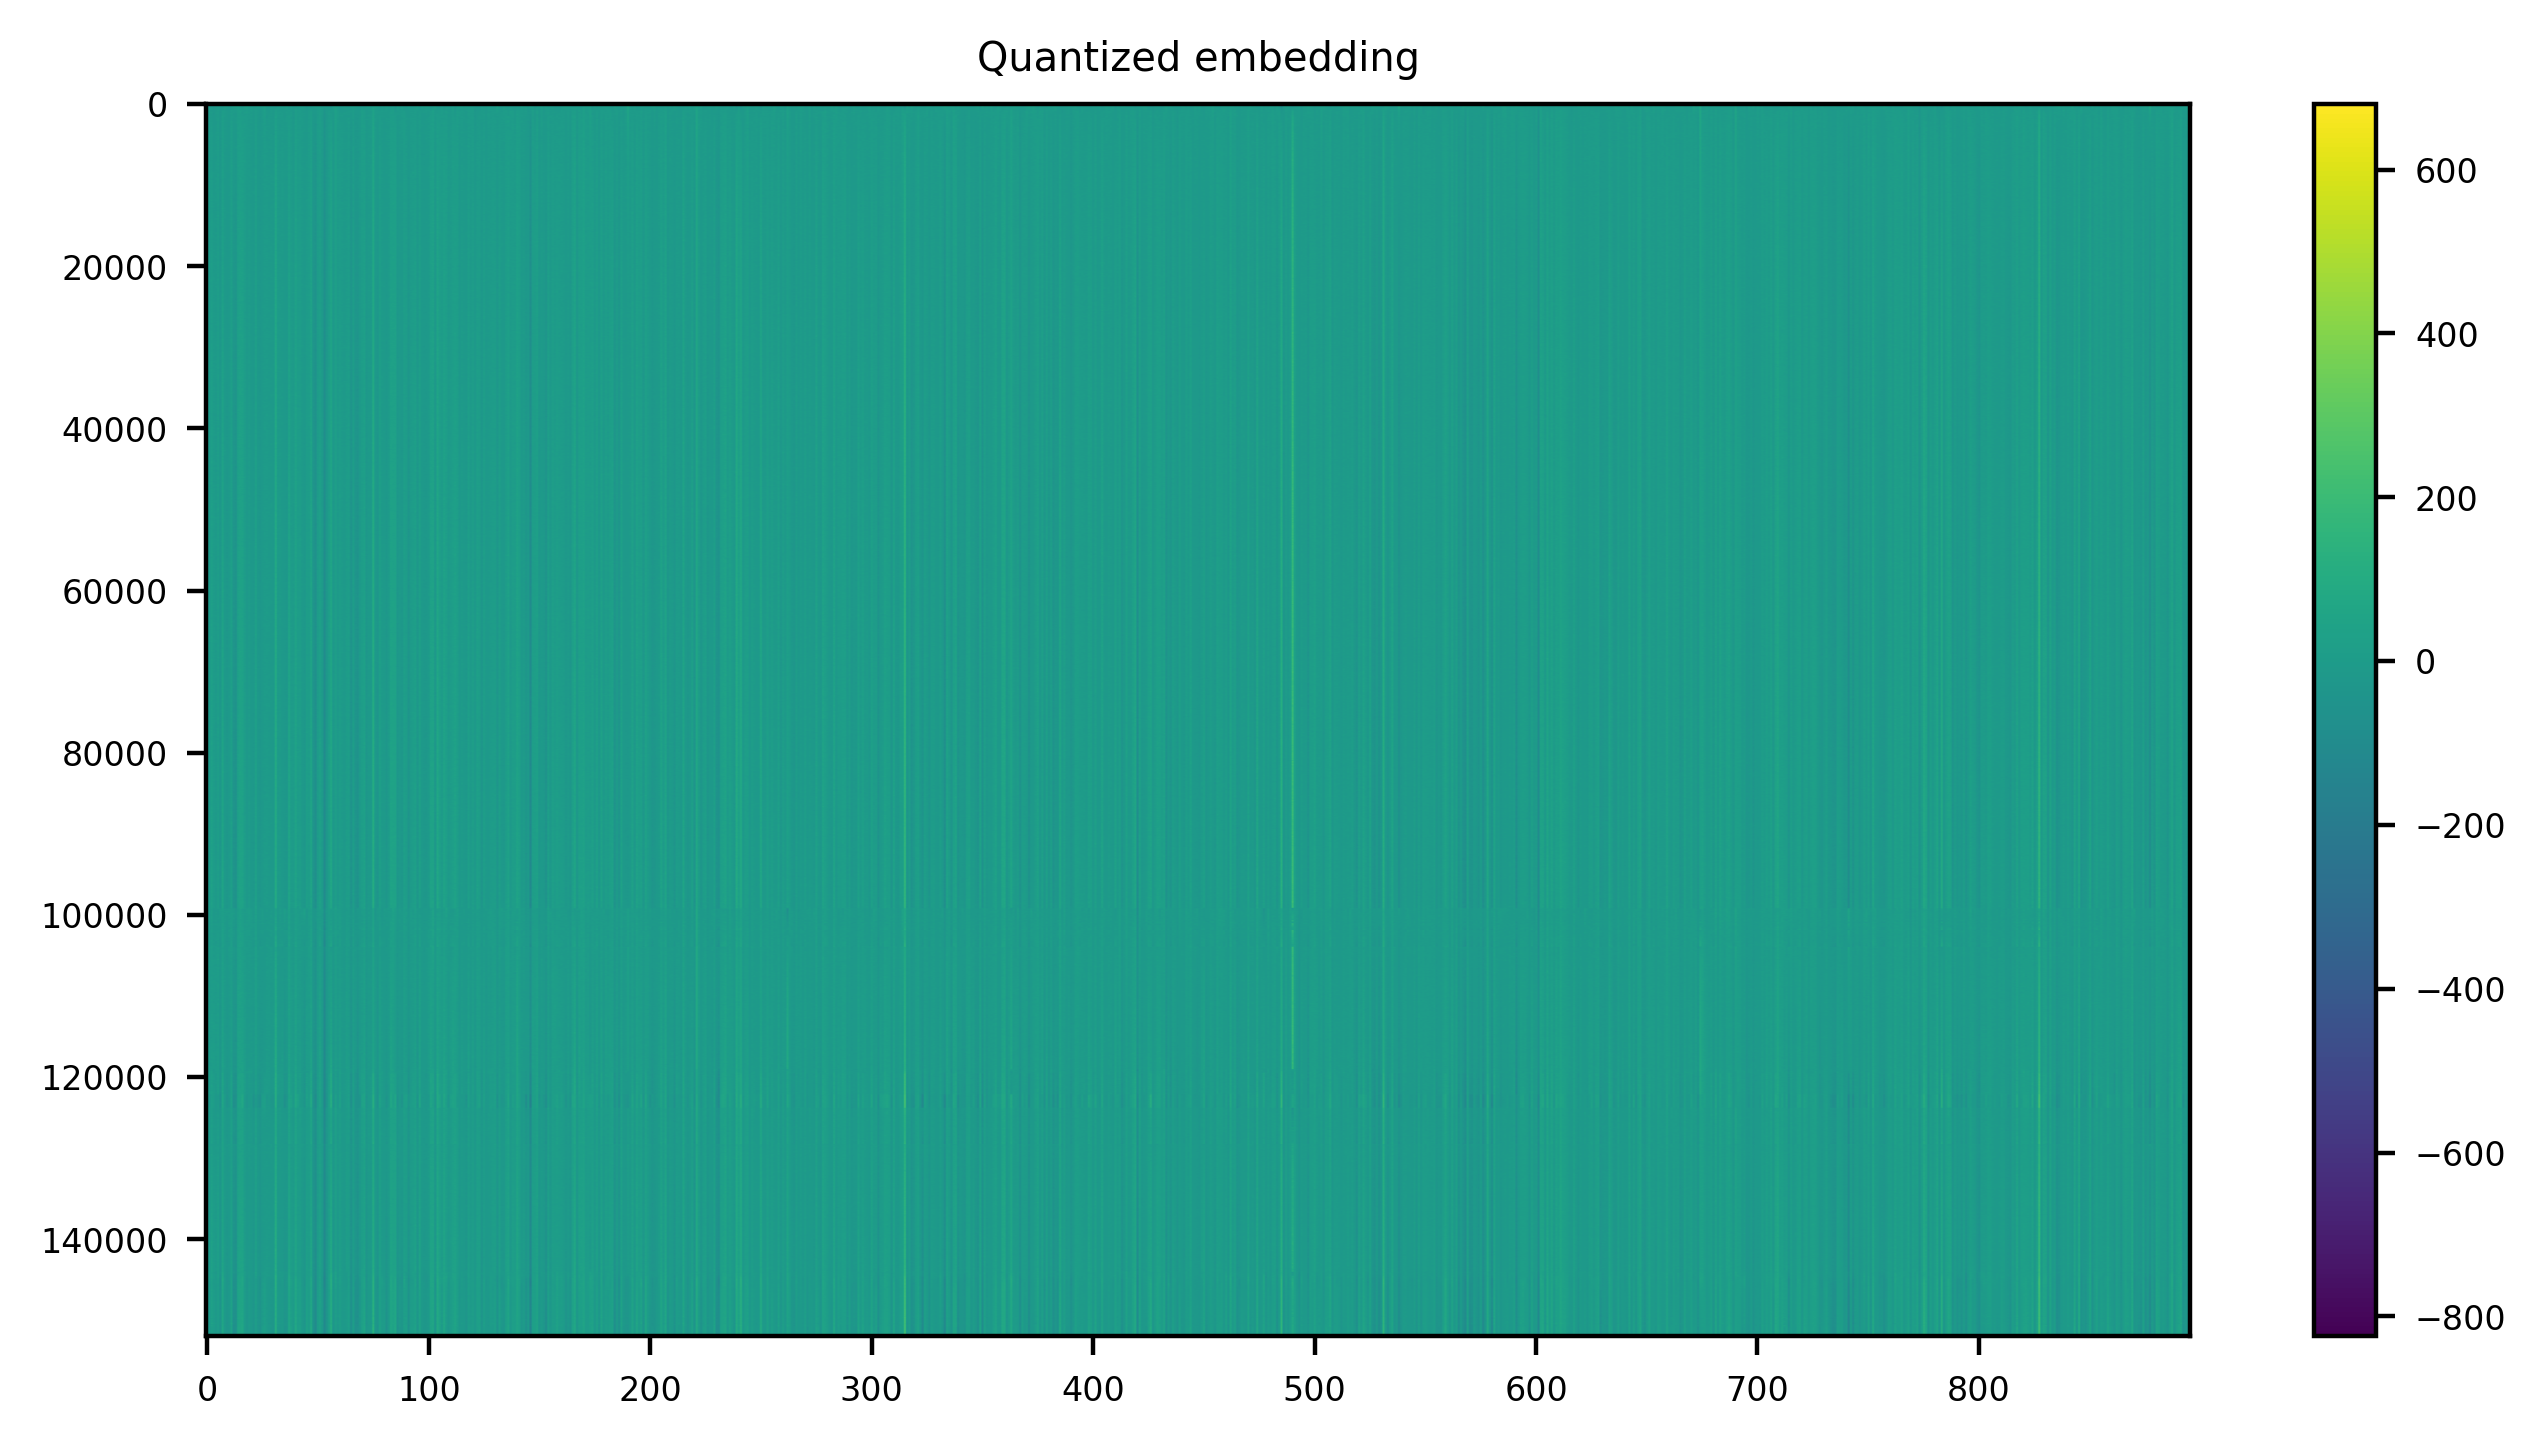

In [13]:
# get embedding matrix
emb = model.get_input_embeddings().weight.data

print(f"Model loaded to {device}")
print(f"Model emb shape: {emb.shape}")

quantized_emb = emb * (2**12)
quantized_emb = quantized_emb.round().to(torch.int16)

# print min max
print(f"Quantized emb min: {quantized_emb.min()}")
print(f"Quantized emb max: {quantized_emb.max()}")

# save this to binaries
# some aux funcs
def save_tensor(t: Union[torch.Tensor, List], dtype, name):
    path = f"binaries/"
    if not os.path.exists(path):
        os.makedirs(path)
    if isinstance(t, list):
        t = torch.tensor(t)
    print(f"Saving {name}, shape: {t.shape}, dtype: {t.dtype}")
    # it's worth noting that, only integer values
    t = t.to(dtype)
    t = t.cpu().detach().numpy().flatten()
    t_str = np.array2string(t[:5], separator=", ", formatter={"int": lambda x: f"{x:12d}"})
    print(f"First 5 elements: {t_str}")
    # concat path
    filename = f"{path}/{name}.bin"
    t.tofile(filename)

# check range, assert in the range of int16
assert quantized_emb.min() >= -2**15 and quantized_emb.max() <= 2**15 - 1
save_tensor(quantized_emb, torch.int16, "EMBEDDING")

# visualize the embedding as a figure
fig = plt.figure()
plt.imshow(quantized_emb.cpu().detach().numpy(), aspect="auto")
plt.colorbar()
plt.title("Quantized embedding")
plt.show()

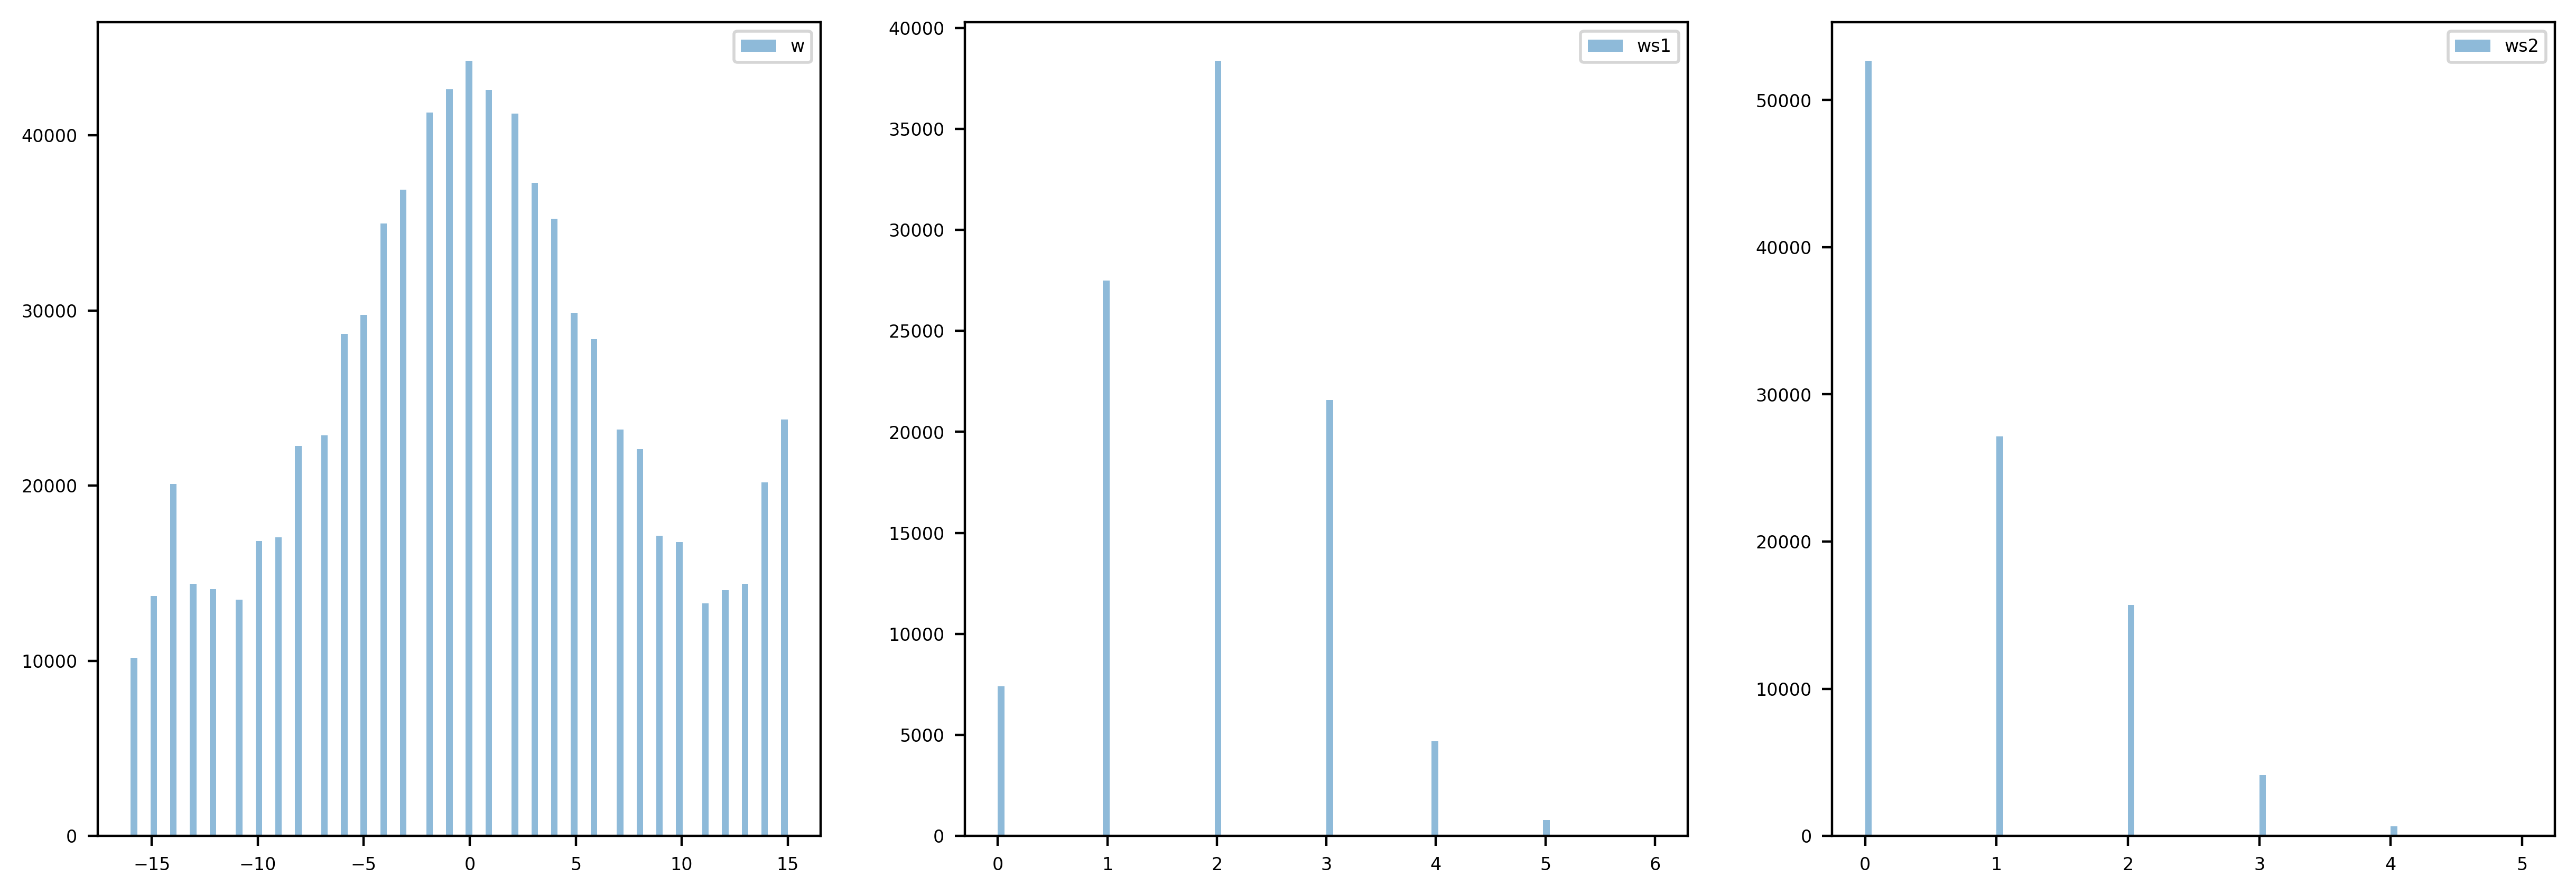

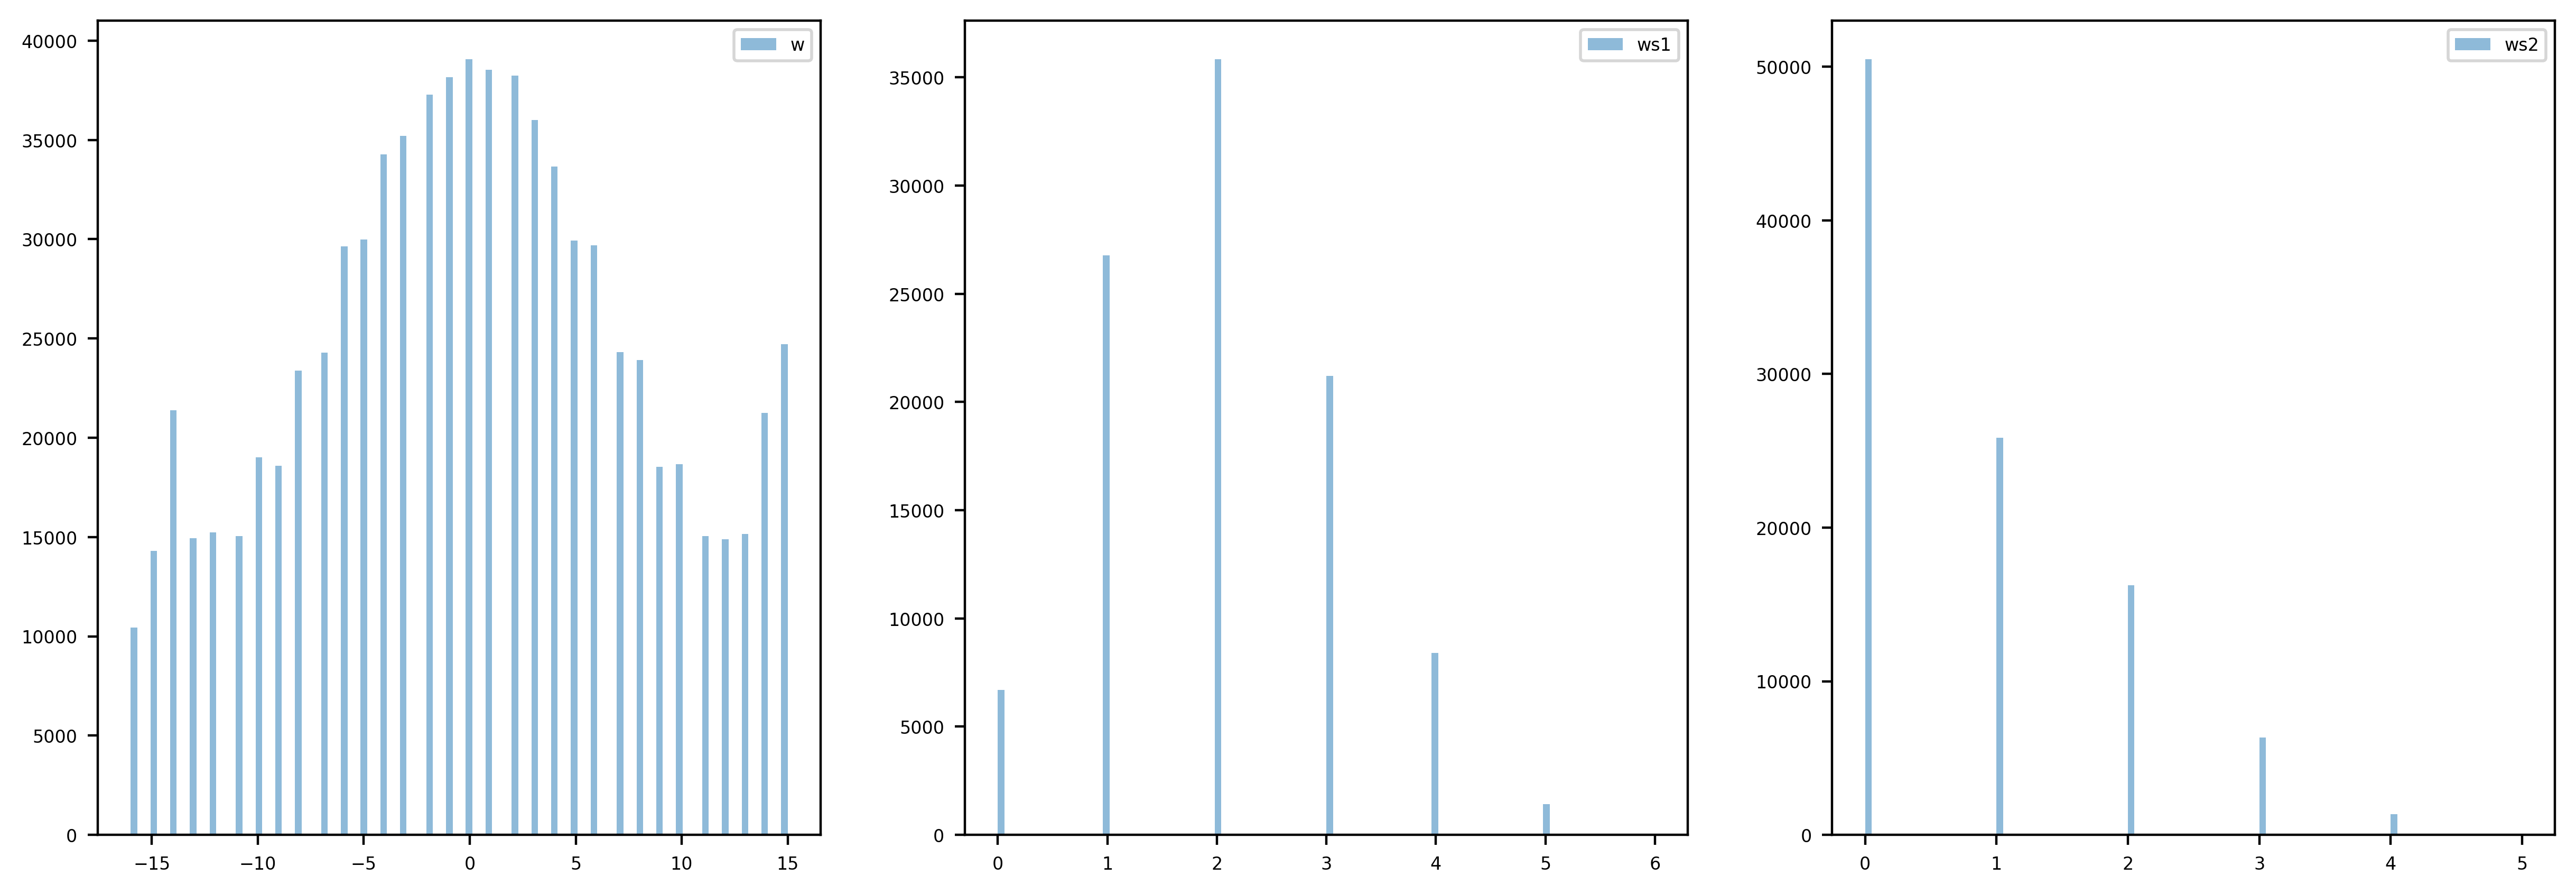

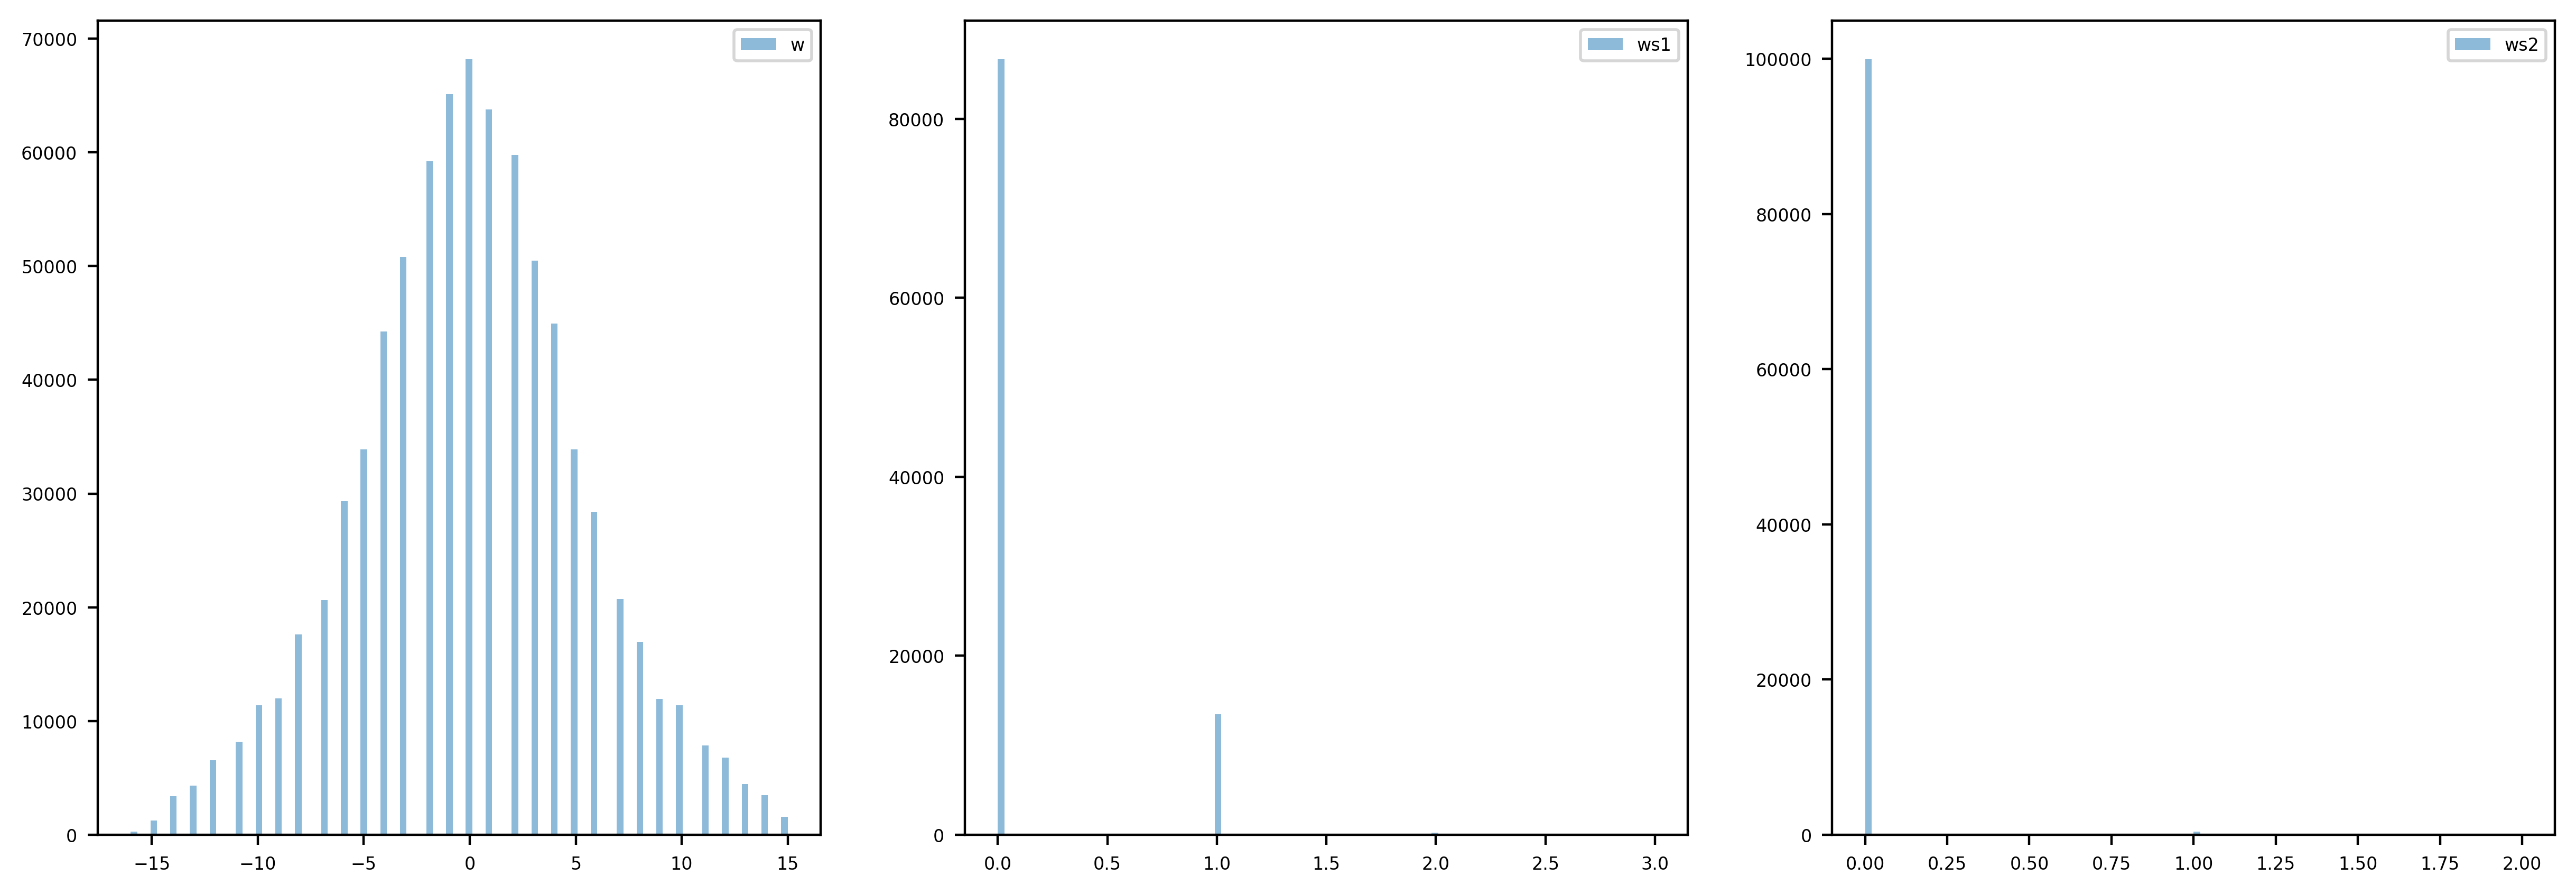

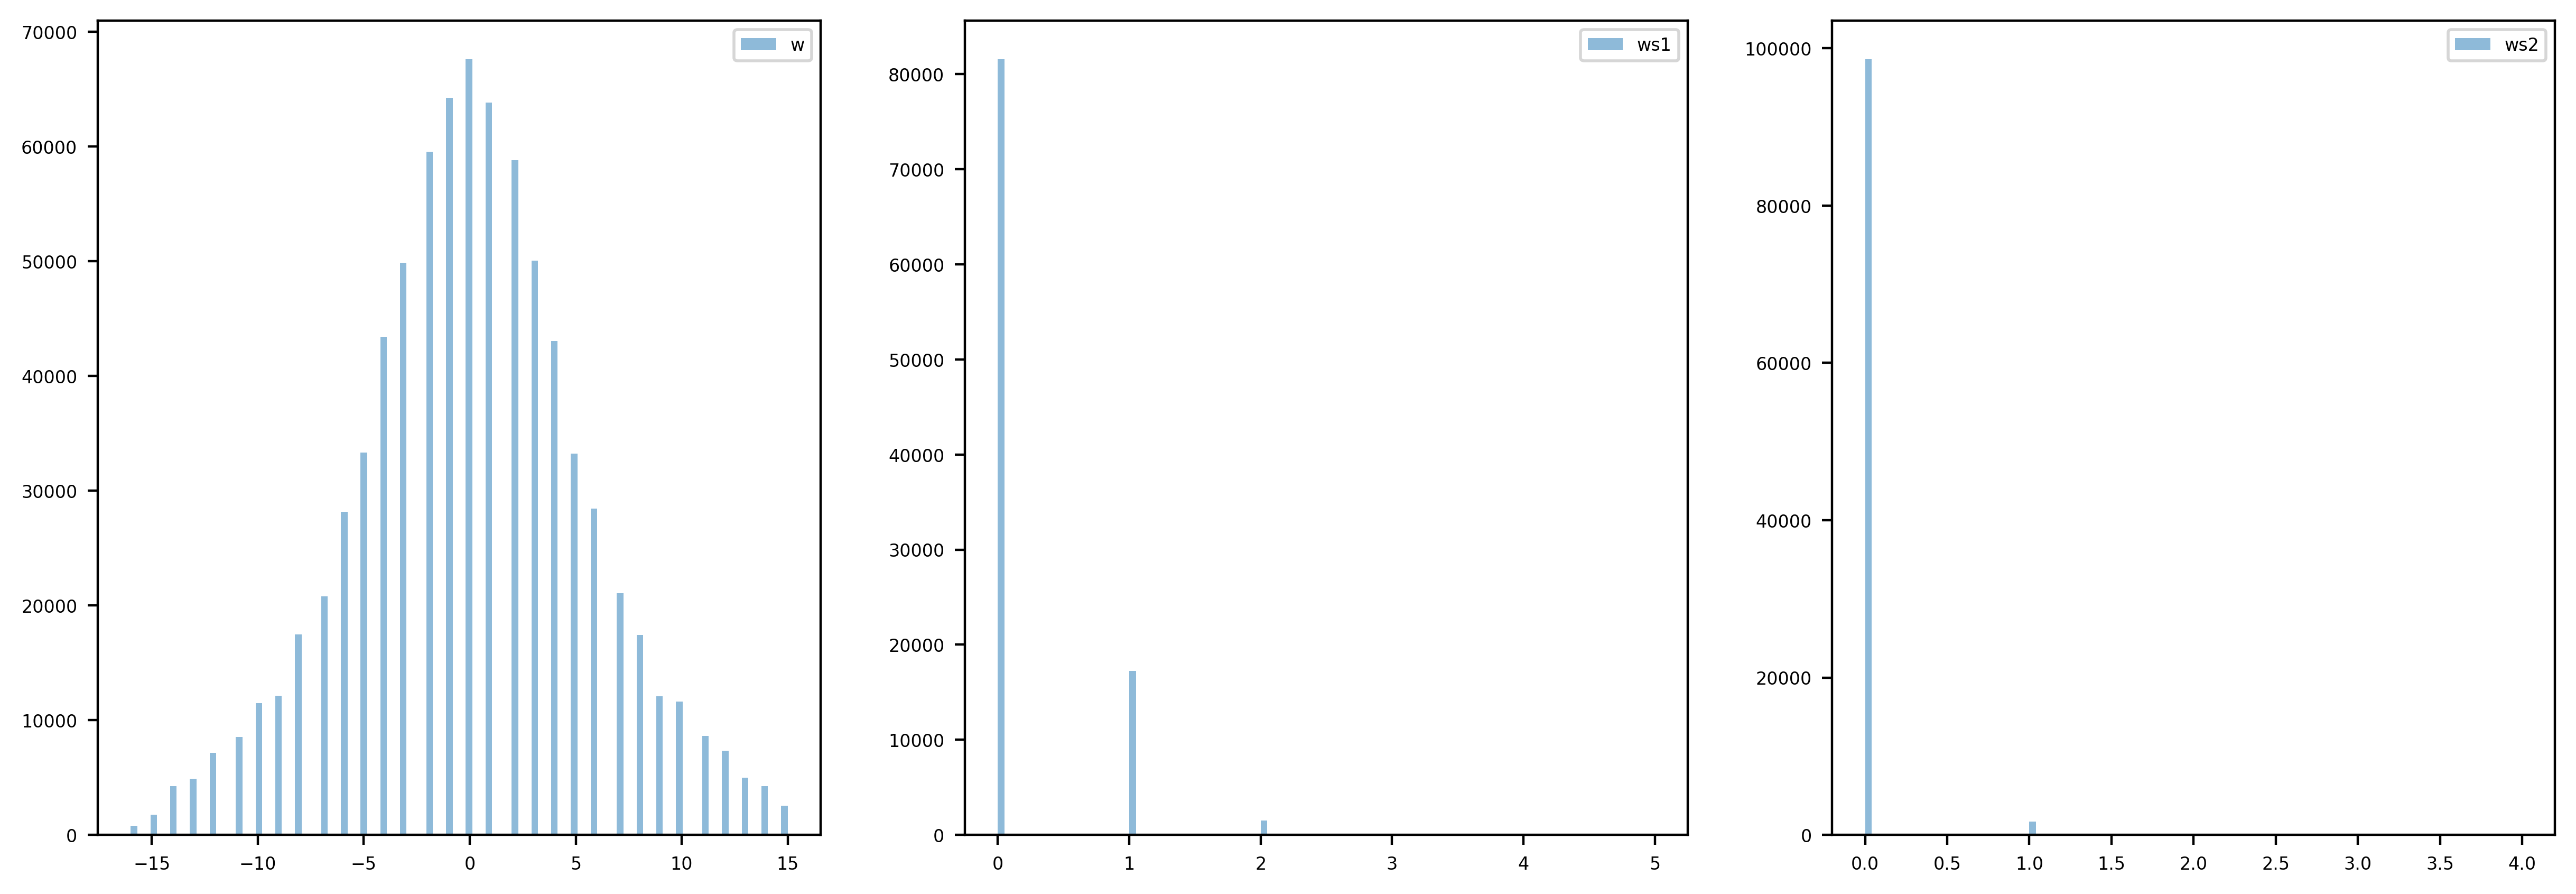

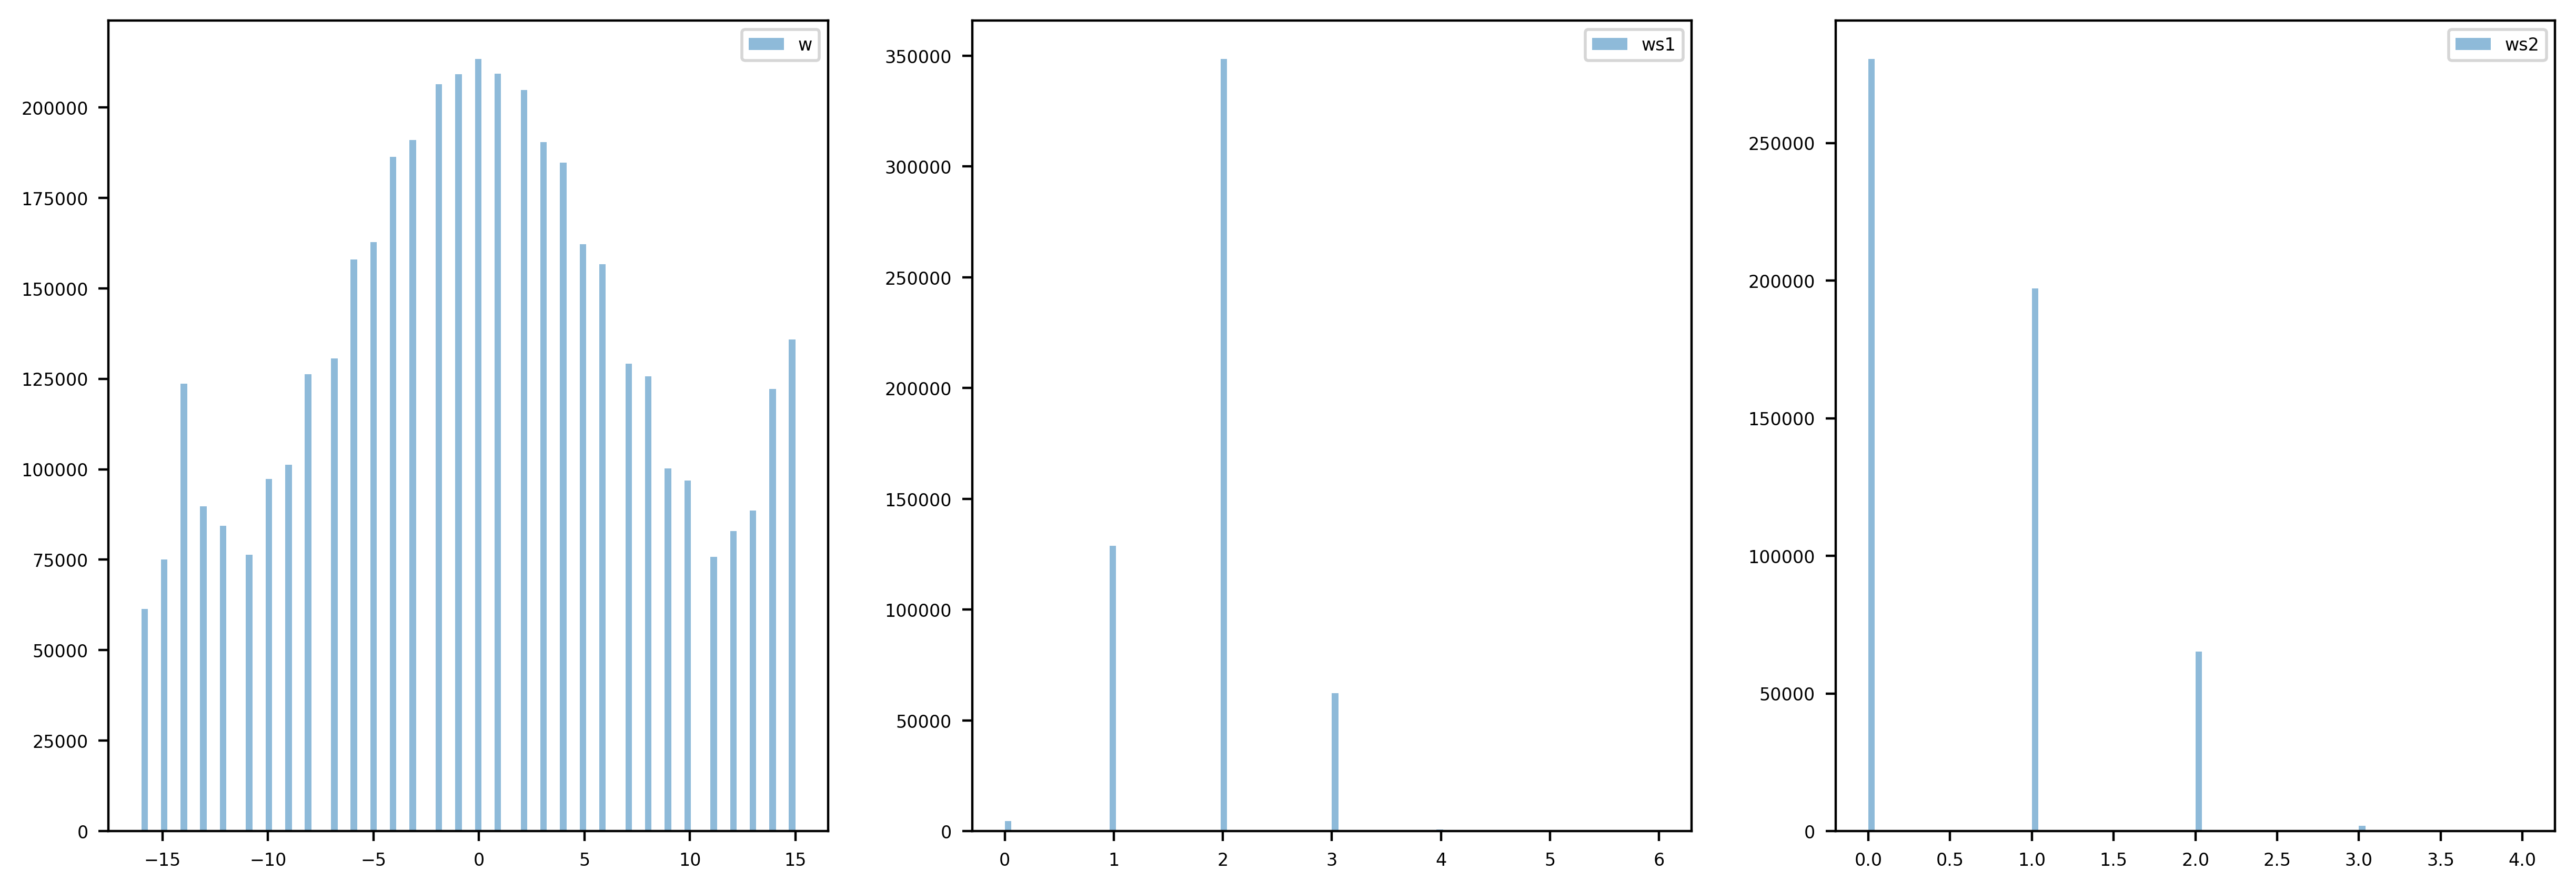

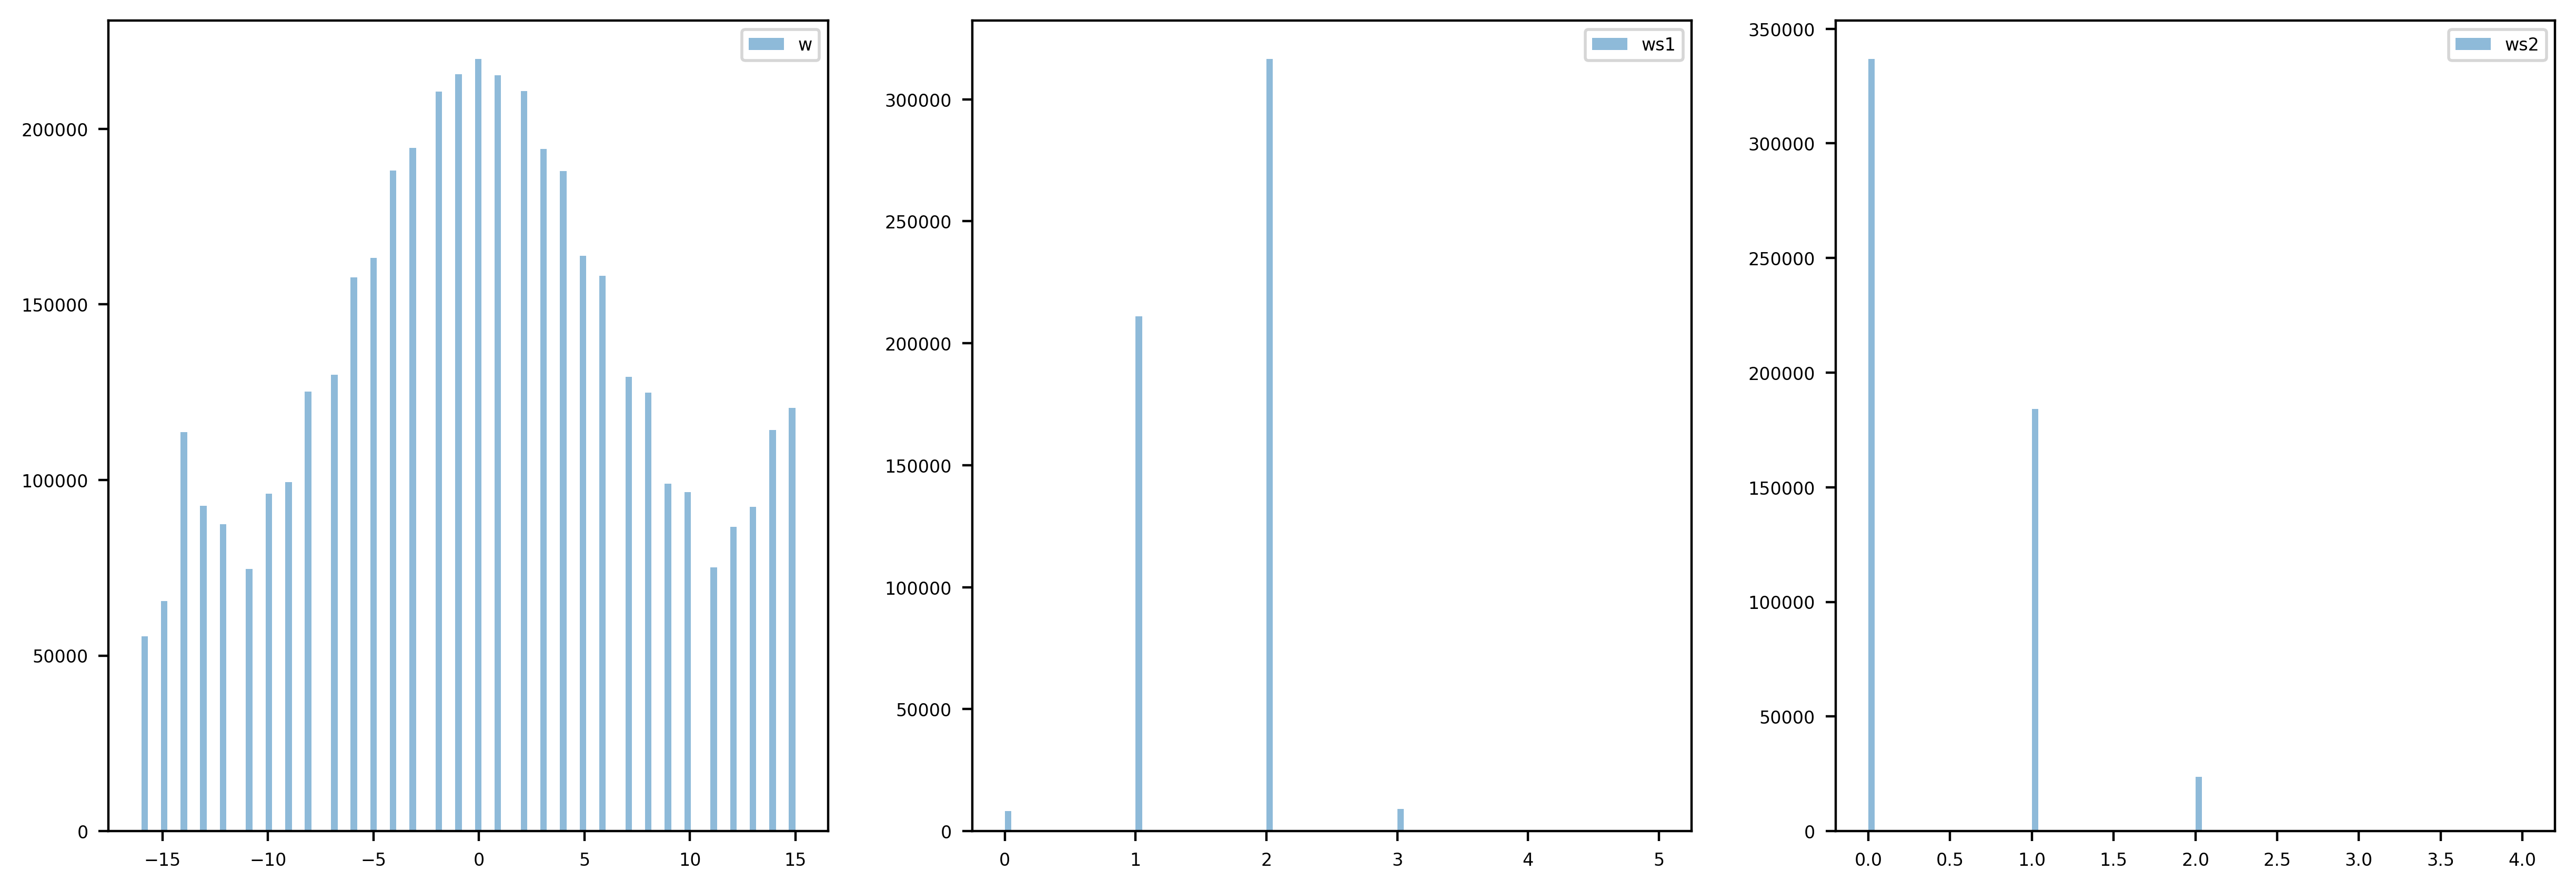

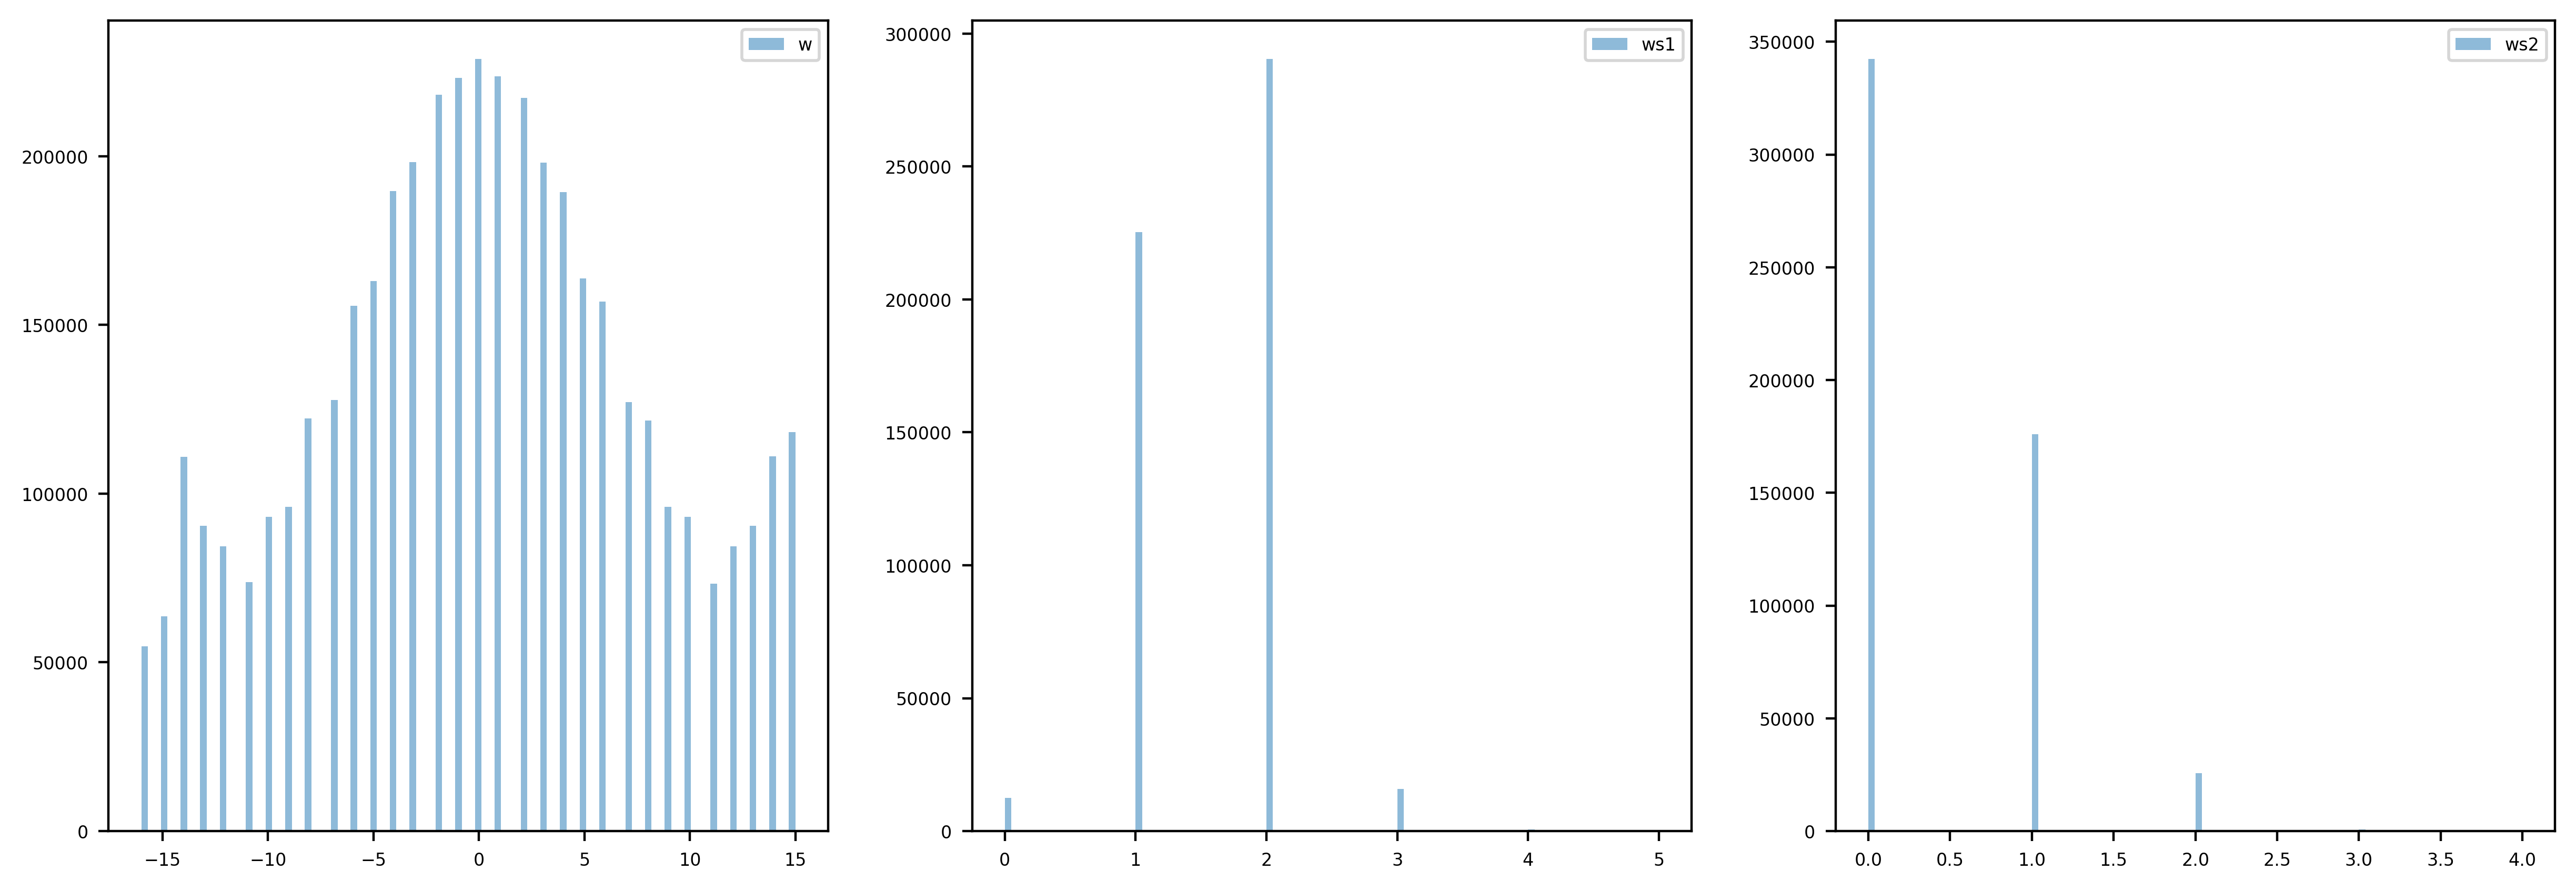

In [12]:
# display some saved tensors
# for decoder0
decoder_id = 0
path = f"binaries/decoder_{decoder_id}/"

def show_weight(name):
    w = np.fromfile(f"{path}/{name}_Q.bin",     dtype=np.int8)
    ws1 = np.fromfile(f"{path}/{name}_S1.bin",  dtype=np.int8)
    ws2 = np.fromfile(f"{path}/{name}_S2.bin",  dtype=np.int8)

    # use subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].hist(w, bins=100, alpha=0.5, label='w')
    axs[0].legend()
    axs[1].hist(ws1, bins=100, alpha=0.5, label='ws1')
    axs[1].legend()
    axs[2].hist(ws2, bins=100, alpha=0.5, label='ws2')
    axs[2].legend()
    plt.show()

show_weight("MHA_WQ")
show_weight("MHA_WK")
show_weight("MHA_WV")
show_weight("MHA_WO")
show_weight("MLP_WG")
show_weight("MLP_WU")
show_weight("MLP_WD")
